# Get relevant packages

In [5]:
import pandas as pd
import numpy as np
#np.set_printoptions(threshold=np.nan)
import re
import matplotlib.pyplot as plt
import seaborn as sns



pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('display.max_colwidth', -1)



# Let's pull in relevant files
See USDA database http://ilsina.org/our-work/research-tools-open-data/bfpd/

In [2]:
products=pd.read_csv('/Users/meleciawright/Google Drive/csvs/products.csv',low_memory=False, encoding='mac_roman')
serving=pd.read_csv('/Users/meleciawright/Google Drive/csvs/Serving_Size.csv',low_memory=False,encoding='mac_roman')
nutrients=pd.read_csv('/Users/meleciawright/Google Drive/csvs/nutrient.csv',low_memory=False,encoding='mac_roman')
dflist=[serving,products, nutrients]
for x in dflist:print(len(x))

237910
239089
3231488


# Change strings to lower case

In [4]:
products['name']=products.long_name.str.lower().str.capitalize()
products['unqname']=products.manufacturer.str.lower().str.capitalize()+': '+products.long_name.str.lower()
products['ingredients']=products.ingredients_english.str.lower().str.capitalize()

products[['name','unqname','ingredients']].head()

,name,unqname,ingredients
0,Mochi ice cream bonbons,"G. t. japan, inc.: mochi ice cream bonbons","Ice cream ingredients: milk, cream, sugar, strawberries (strawberries, sugar), corn syrup solids, skim milk, whey, natural flavor, guar gum, mono & diglycerides, beet juice and beet powder (for color), cellulose gum, locust bean gum, carrageenan. coating ingredients: sugar, water, rice flour, trehalose, egg whites, beet juice and beet powder (for color), dusted with corn & potato starch"
1,Chipotle barbecue sauce,Fresh & easy: chipotle barbecue sauce,"Water, sugar, tomato paste, molasses, distilled vinegar, contains 2% or less of: corn starch, salt, dried chipotle pepper, natural smoke flavor, mustard flour, dried garlic, dried onion, spices."
2,Hot & spicy barbecue sauce,Fresh & easy: hot & spicy barbecue sauce,"Sugar, water, distilled vinegar, tomato paste, molasses, modified corn starch, salt, pineapple juice concentrate, contains 1% or less of: jalapeno peppers, spice, caramel color, natural flavor, xanthan gum, garlic powder, tamarind extract."
3,Barbecue sauce,Fresh & easy: barbecue sauce,"Tomato puree (water, tomato paste), sugar, distilled vinegar, molasses, water, modified corn starch, salt, bourbon whiskey, contains 1% or less of: mustard flour, spice, dried onion, dried garlic, natural flavor, xanthan gum, caramel color."
4,Barbecue sauce,Fresh & easy: barbecue sauce,"Sugar, distilled vinegar, water, tomato paste, honey, molasses, modified corn starch, salt, contains 1% or less of: natural flavor, pineapple juice concentrate, spice, caramel color, xanthan gum, garlic powder, tamarind extract."


# Check for duplicates

In [4]:
(products.name.nunique(),products.unqname.nunique(),products.ingredients.nunique(),products.unqname.notnull().sum(),
 products.ingredients.notnull().sum(),products.gtin_upc.nunique())
#all UPC codes are unique but there are some product names that are similar, and after merging manufacturer info
#with product names there are still ~45000 that are not unique. For simplicity, I will drop the non-unique productnames

(147794, 194279, 176656, 238258, 236539, 239089)

In [5]:
#products2=products[products.unqname.notnull()].drop_duplicates(subset=['unqname']) 
products2=products.drop_duplicates(subset=['ingredients']) 
products2=products2.drop_duplicates(subset=['unqname']) 

products2.ingredients.nunique()

152412

# Let's see the nutrient file

In [13]:
nutrients.head()
#goal here is to create a wide version so that each row has the nutrient within individual product IDs

,NDB_No,Nutrient_Code,Nutrient_name,Derivation_Code,Output_value,Output_uom
0,45127487,203,Protein,LCGA,4.3,g
1,45127487,204,Total lipid (fat),LCGA,18.9,g
2,45127487,205,"Carbohydrate, by difference",LCGA,72.8,g
3,45127487,207,Ash,LCGA,2.0,g
4,45127487,255,Water,LCGA,2.0,g


In [14]:
nutrients.Nutrient_name.value_counts()

Carbohydrate, by difference           237635
Total lipid (fat)                     237559
Protein                               237432
Sodium, Na                            236887
Energy                                228500
Sugars, total                         223394
Fatty acids, total saturated          205694
Cholesterol                           202966
Fiber, total dietary                  198171
Iron, Fe                              196981
Calcium, Ca                           196065
Fatty acids, total trans              194801
Vitamin C, total ascorbic acid        178809
Vitamin A, IU                         174501
Potassium, K                          53337 
Fatty acids, total monounsaturated    33822 
Fatty acids, total polyunsaturated    33799 
Vitamin D                             27668 
Niacin                                16071 
Thiamin                               15579 
Riboflavin                            15234 
Sugars, added                         11033 
Vitamin B-

In [15]:
#example nutrient data
nutrients[nutrients.Nutrient_name=='Carbohydrate, by difference'].describe()

,NDB_No,Nutrient_Code,Output_value
count,2.376350e+05,237635.0,237635.000000
mean,4.520707e+07,205.0,33.574563
std,1.023677e+05,0.0,29.423991
min,4.500152e+07,205.0,0.000000
25%,4.513822e+07,205.0,6.670000
50%,4.520950e+07,205.0,23.530000
75%,4.528504e+07,205.0,60.000000
max,4.537643e+07,205.0,100.000000


In [6]:
#only keep the nutrients that'll form the basis of recommendation
nutrientstokeep=['Total lipid (fat)',  'Carbohydrate, by difference','Sugars, total', 'Protein','Energy']
nutrprun=nutrients.loc[nutrients['Nutrient_name'].isin(nutrientstokeep)].drop_duplicates(['NDB_No','Nutrient_name']) 
nutrprun.Nutrient_name.value_counts()

Carbohydrate, by difference    237635
Total lipid (fat)              237559
Protein                        237432
Energy                         228494
Sugars, total                  223394
Name: Nutrient_name, dtype: int64

In [8]:
nutrprun.head(),len(nutrprun)

(      NDB_No  Nutrient_Code                Nutrient_name Derivation_Code  Output_value Output_uom
 0   45127487  203            Protein                      LCGA            4.3           g        
 1   45127487  204            Total lipid (fat)            LCGA            18.9          g        
 2   45127487  205            Carbohydrate, by difference  LCGA            72.8          g        
 5   45127487  269            Sugars, total                LCGA            39.3          g        
 29  45128706  203            Protein                      LCGA            10.1          g        ,
 1164520)

In [7]:
#transpose file from long to wide so each product id only occupies a single row
nutrientl=nutrprun.copy()
nutrientw=nutrientl.pivot(index='NDB_No',columns='Nutrient_name', values='Output_value')
nutrientw.head()

Nutrient_name,"Carbohydrate, by difference",Energy,Protein,"Sugars, total",Total lipid (fat)
NDB_No,,,,,
45001524,35.00,200.0,2.5,30.00,6.25
45001528,43.24,162.0,0.0,37.84,0.00
45001529,41.18,176.0,0.0,35.29,0.00
45001530,34.29,143.0,0.0,28.57,0.00
45001531,45.95,189.0,0.0,43.24,0.00


In [12]:
4*(2.5+35)+6.25*9# the energy column seems off. will recalculate since there's not additional information from the datasource

206.25

In [8]:
nutrientw['energy (kcal)']=4*(nutrientw['Carbohydrate, by difference']+nutrientw['Protein'])+9*nutrientw['Total lipid (fat)']
nutrientw.head()

Nutrient_name,"Carbohydrate, by difference",Energy,Protein,"Sugars, total",Total lipid (fat),energy (kcal)
NDB_No,,,,,,
45001524,35.00,200.0,2.5,30.00,6.25,206.25
45001528,43.24,162.0,0.0,37.84,0.00,172.96
45001529,41.18,176.0,0.0,35.29,0.00,164.72
45001530,34.29,143.0,0.0,28.57,0.00,137.16
45001531,45.95,189.0,0.0,43.24,0.00,183.80


In [14]:
nutrientw.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 237829 entries, 45001524 to 45376431
Data columns (total 6 columns):
Carbohydrate, by difference    237635 non-null float64
Energy                         228494 non-null float64
Protein                        237432 non-null float64
Sugars, total                  223394 non-null float64
Total lipid (fat)              237559 non-null float64
energy (kcal)                  237095 non-null float64
dtypes: float64(6)
memory usage: 12.7 MB


In [15]:
nutrientw.describe()

/Users/meleciawright/anaconda/lib/python3.5/site-packages/numpy/lib/function_base.py:3821: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


Nutrient_name,"Carbohydrate, by difference",Energy,Protein,"Sugars, total",Total lipid (fat),energy (kcal)
count,237635.000000,228494.000000,237432.000000,223394.000000,237559.000000,237095.000000
mean,33.574563,268.639076,6.948195,16.768423,12.215180,271.999261
std,29.423991,189.406041,8.236374,21.546119,16.981679,193.475762
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,NaN,NaN,NaN,NaN,NaN
max,100.000000,2857.000000,100.000000,100.000000,100.000000,1300.000000


In [16]:
for col in nutrientw.columns: print (col, nutrientw[col].isnull().sum())

Carbohydrate, by difference 194
Energy 9335
Protein 397
Sugars, total 14435
Total lipid (fat) 270
energy (kcal) 734


In [12]:
#some items are null
nutrientw.info()
print(len(nutrientw))
nutrientw=nutrientw.dropna()
print(len(nutrientw))


#nutrientw=nutrientw.fillna(0)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 237829 entries, 45001524 to 45376431
Data columns (total 6 columns):
Carbohydrate, by difference    237635 non-null float64
Energy                         228494 non-null float64
Protein                        237432 non-null float64
Sugars, total                  223394 non-null float64
Total lipid (fat)              237559 non-null float64
energy (kcal)                  237095 non-null float64
dtypes: float64(6)
memory usage: 12.7 MB
237829
213740


In [13]:
nutrientw=nutrientw.reset_index()#grab the product id back and make it a column
print(nutrientw.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 213740 entries, 0 to 213739
Data columns (total 7 columns):
NDB_No                         213740 non-null int64
Carbohydrate, by difference    213740 non-null float64
Energy                         213740 non-null float64
Protein                        213740 non-null float64
Sugars, total                  213740 non-null float64
Total lipid (fat)              213740 non-null float64
energy (kcal)                  213740 non-null float64
dtypes: float64(6), int64(1)
memory usage: 11.4 MB
None


# add serving
this way we can normalize nutrient by serving size

In [11]:
serving.head()

,NDB_No,Serving_Size,Serving_Size_UOM,Household_Serving_Size,Household_Serving_Size_UOM,Preparation_State
0,45001524,40.0,g,1.0,PIECE,NaN
1,45001528,37.0,g,2.0,Tbsp,NaN
2,45001529,34.0,g,2.0,Tbsp,NaN
3,45001530,35.0,g,2.0,Tbsp,NaN
4,45001531,37.0,g,2.0,Tbsp,NaN


In [14]:
#use servings so you can create a normalized nutrient density for each item
#remove those with missing serving size
allnutrsv=pd.merge(nutrientw,serving[serving.Serving_Size.notnull()], on='NDB_No',how='outer')
allnutrsv.head()

Nutrient_name,NDB_No,"Carbohydrate, by difference",Energy,Protein,"Sugars, total",Total lipid (fat),energy (kcal),Serving_Size,Serving_Size_UOM,Household_Serving_Size,Household_Serving_Size_UOM,Preparation_State
0,45001524.0,35.00,200.0,2.5,30.00,6.25,206.25,40.0,g,1.0,PIECE,NaN
1,45001528.0,43.24,162.0,0.0,37.84,0.00,172.96,37.0,g,2.0,Tbsp,NaN
2,45001529.0,41.18,176.0,0.0,35.29,0.00,164.72,34.0,g,2.0,Tbsp,NaN
3,45001530.0,34.29,143.0,0.0,28.57,0.00,137.16,35.0,g,2.0,Tbsp,NaN
4,45001531.0,45.95,189.0,0.0,43.24,0.00,183.80,37.0,g,2.0,Tbsp,NaN


In [15]:
allnutrsv.Serving_Size_UOM.value_counts()
#should be fine to divide since majority of units are expressed in grams and will not be using beverages
#(ml) in these analyses

g     206950
ml    30925 
Name: Serving_Size_UOM, dtype: int64

In [36]:
allnutrsv.columns

Index(['NDB_No', 'Carbohydrate, by difference', 'Energy', 'Protein', 'Sugars, total', 'Total lipid (fat)', 'energy (kcal)', 'Serving_Size', 'Serving_Size_UOM', 'Household_Serving_Size', 'Household_Serving_Size_UOM', 'Preparation_State'], dtype='object', name='Nutrient_name')

In [17]:
allnutrsv.columns=['NDB_No', 'Carbs (g)', 'Energy', 'Protein (g)', 'Sugars (g)', 'Fat (g)', 'Energy (kcal)', 'Serving_Size', 'Serving_Size_UOM', 'Household_Serving_Size', 'Household_Serving_Size_UOM', 'Preparation_State']

In [18]:
#standardize so that nutrients are all out of a serving_size of 100
def serv100(col) :
    allnutrsv[col]= round(100*allnutrsv[col]/ allnutrsv['Serving_Size']) 
    return 
for coll in ['Fat (g)','Protein (g)','Sugars (g)','Carbs (g)','Energy (kcal)']:
    serv100(coll)
allnutrsv.head()

,NDB_No,Carbs (g),Energy,Protein (g),Sugars (g),Fat (g),Energy (kcal),Serving_Size,Serving_Size_UOM,Household_Serving_Size,Household_Serving_Size_UOM,Preparation_State
0,45001524.0,88.0,200.0,6.0,75.0,16.0,516.0,40.0,g,1.0,PIECE,NaN
1,45001528.0,117.0,162.0,0.0,102.0,0.0,467.0,37.0,g,2.0,Tbsp,NaN
2,45001529.0,121.0,176.0,0.0,104.0,0.0,484.0,34.0,g,2.0,Tbsp,NaN
3,45001530.0,98.0,143.0,0.0,82.0,0.0,392.0,35.0,g,2.0,Tbsp,NaN
4,45001531.0,124.0,189.0,0.0,117.0,0.0,497.0,37.0,g,2.0,Tbsp,NaN


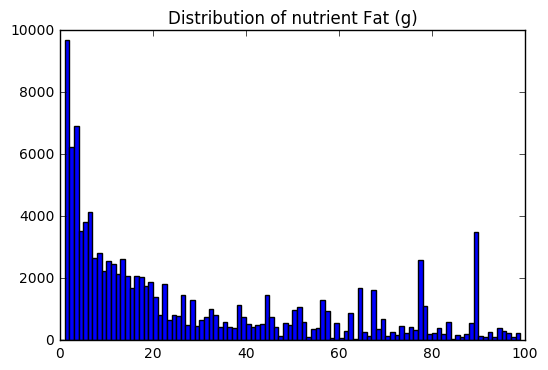

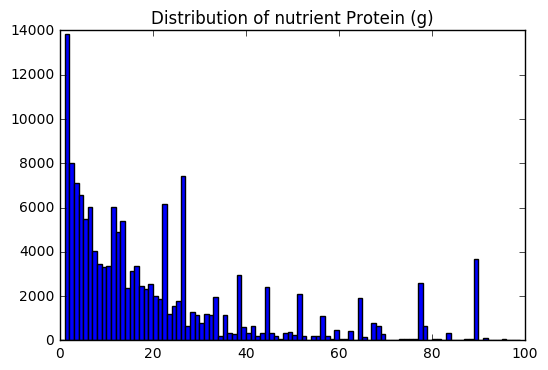

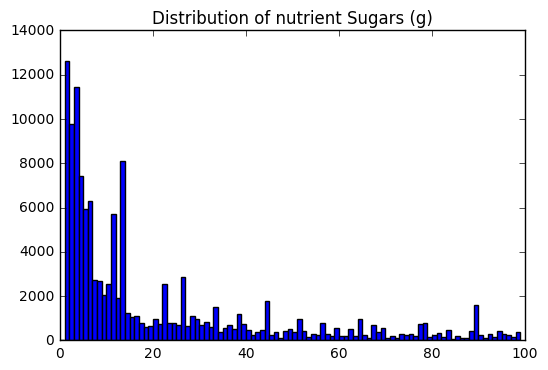

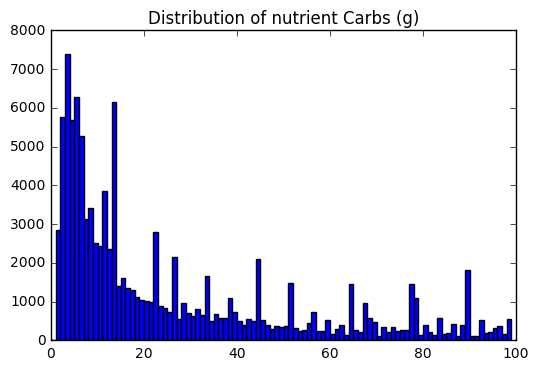

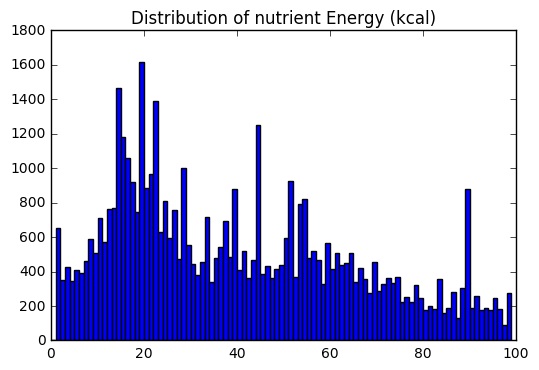

In [19]:
for x in ['Fat (g)','Protein (g)','Sugars (g)','Carbs (g)','Energy (kcal)']:
    plt.hist(allnutrsv[x][allnutrsv[x]!=0] ,range(0,100) )
    plt.title('Distribution of nutrient '+x)
    plt.show()

In [699]:
nutrpro=pd.merge(allnutrsv,products2, right_on='NDB_Number', left_on='NDB_No',  how= 'inner')
nutrpro.head() 
nlist= ['Energy (kcal)','Protein (g)','Fat (g)','Carbs (g)','Sugars (g)']


for x in [nutrpro,allnutrsv,products2]:print(len(x), x.info())
for n in nlist:print(nutrpro[n].isnull().sum())

#though some nutrient information is missing, inspect further to see how, why, or just delete, in the interest of 
#retaining a larger body of data I'll just fill for now
 
nutrpro=nutrpro.fillna(0)


for x in [nutrpro,allnutrsv,products2]:print(len(x), x.info())
for n in nlist:print(nutrpro[n].isnull().sum())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 152093 entries, 0 to 152092
Data columns (total 23 columns):
NDB_No                        152093 non-null float64
Carbs (g)                     138240 non-null float64
Energy                        138255 non-null float64
Protein (g)                   138240 non-null float64
Sugars (g)                    138240 non-null float64
Fat (g)                       138240 non-null float64
Energy (kcal)                 138240 non-null float64
Serving_Size                  152078 non-null float64
Serving_Size_UOM              152078 non-null object
Household_Serving_Size        151420 non-null float64
Household_Serving_Size_UOM    151517 non-null object
Preparation_State             5892 non-null object
NDB_Number                    152093 non-null int64
long_name                     152093 non-null object
data_source                   152093 non-null object
gtin_upc                      152093 non-null object
manufacturer                  15209

# create product categories

 enough product categories appear in the product name so feasible to just extract some from that source

In [60]:
nutrpro['pcat']=None

In [61]:
pasta=['pasta','macaroni','rotini','bowtie','elbow','tortellin','raviol','farfall','spaghett','fusill',
      'ziti','fetuccin','angel hair','linguin','rotini','macaroni','pasta']    
for x in pasta:
    nutrpro.loc[nutrpro['name'].str.contains(x) & nutrpro['pcat'].isnull(), 'pcat'] = 'pasta'

In [62]:
nutrpro.loc[nutrpro['name'].str.contains('yogurt') & nutrpro['pcat'].isnull(), 'pcat'] = 'yogurt'
nutrpro.loc[nutrpro['name'].str.contains('soup') & nutrpro['pcat'].isnull(), 'pcat'] = 'soup'
nutrpro.loc[nutrpro['name'].str.contains('ice cream') & nutrpro['pcat'].isnull(), 'pcat'] = 'ice cream'
nutrpro.pcat.value_counts()

pasta        2975
yogurt       2615
soup         2033
ice cream    1852
Name: pcat, dtype: int64

In [63]:
meats= ['burger','patties','patty','sausage','hot dog','meatball']  
for x in meats:
    nutrpro.loc[~nutrpro['name'].str.contains('veg') &
                    ~nutrpro['name'].str.contains('porto') &
                    nutrpro['name'].str.contains(x) & nutrpro['pcat'].isnull(), 'pcat'] = 'meatburger'
nutrpro.pcat.value_counts()

meatburger    3502
pasta         2975
yogurt        2615
soup          2033
ice cream     1852
Name: pcat, dtype: int64

In [64]:
nutrpro[nutrpro.pcat=='meatburger'].head()

,NDB_No,Carbs (g),Energy,Protein (g),Sugars (g),Fat (g),Energy (kcal),Serving_Size,Serving_Size_UOM,Household_Serving_Size,Household_Serving_Size_UOM,Preparation_State,NDB_Number,long_name,data_source,gtin_upc,manufacturer,date_modified,date_available,ingredients_english,name,unqname,ingredients,pcat
134,45001811.0,0.0,156.0,20.0,0.0,6.0,137.0,112.0,g,1.000,PIECE,NaN,45001811,ATLANTIC SALMON BURGERS,LI,830859001787,The MacKnight Food Group,8/27/2017 1:28:14,8/27/2017 1:28:14,"ATLANTIC SALMON (94%), BREAD CRUMBS, SALT, LEMON POWDER, CUMIN, CORIANDER, ONION POWDER, GARLIC POWDER.",Atlantic salmon burgers,The macknight food group: atlantic salmon burgers,"Atlantic salmon (94%), bread crumbs, salt, lemon powder, cumin, coriander, onion powder, garlic powder.",meatburger
151,45001859.0,9.0,146.0,22.0,0.0,20.0,297.0,48.0,g,3.000,SAUSAGES,NaN,45001859,REDUCED FAT VIENNA SAUSAGE,LI,011110850119,The Kroger Co.,3/11/2018 4:47:29,3/11/2018 4:47:29,"SAUSAGE: MECHANICALLY SEPARATED CHICKEN, WATER, SALT, MODIFIED CORN STARCH, CONTAINS 2% OR LESS OF: BEEF, PORK, CORN SYRUP, DEXTROSE, NATURAL FLAVORS, SODIUM NITRATE, GARLIC POWDER, BROTH: CHICKEN BROTH.",Reduced fat vienna sausage,The kroger co.: reduced fat vienna sausage,"Sausage: mechanically separated chicken, water, salt, modified corn starch, contains 2% or less of: beef, pork, corn syrup, dextrose, natural flavors, sodium nitrate, garlic powder, broth: chicken broth.",meatburger
152,45001860.0,4.0,208.0,26.0,0.0,35.0,434.0,48.0,g,3.000,SAUSAGES,NaN,45001860,CHICKEN VIENNA SAUSAGE IN CHICKEN BROTH,LI,011110849991,The Kroger Co.,4/27/2018 11:09:19,4/27/2018 11:09:19,"SAUSAGE: MECHANICALLY SEPARATED CHICKEN, WATER, SALT. CONTAINS 2% OR LESS OF: CORN SYRUP DEXTROSE, SODIUM ERYTHORBATE, NATURAL FLAVORS, SODIUM NITRITE, GARLIC POWDER. BROTH: CHICKEN BROTH.",Chicken vienna sausage in chicken broth,The kroger co.: chicken vienna sausage in chicken broth,"Sausage: mechanically separated chicken, water, salt. contains 2% or less of: corn syrup dextrose, sodium erythorbate, natural flavors, sodium nitrite, garlic powder. broth: chicken broth.",meatburger
241,45002204.0,0.0,257.0,15.0,0.0,18.0,222.0,113.0,g,1.000,BURGER,NaN,45002204,GROUND BEEF BURGERS (OMAHA STEAKS BURGERS),LI,021613013256,Omaha Steaks International,4/30/2018 16:22:02,4/30/2018 16:22:02,GROUND BEEF.,Ground beef burgers (omaha steaks burgers),Omaha steaks international: ground beef burgers (omaha steaks burgers),Ground beef.,meatburger
248,45002245.0,20.0,252.0,9.0,3.0,10.0,205.0,119.0,g,0.333,PIZZA,NaN,45002245,"CULINARY CIRCLE, ITALIAN SAUSAGE AND CARAMELIZED ONION PIZZA",LI,041130387715,"Supervalu, Inc.",12/5/2017 0:49:02,12/5/2017 0:49:02,"TOPPINGS: LOW MOISTURE MOZZARELLA CHEESE (PASTEURIZED MILK, CHEESE CULTURES, SALT, ENZYMES), SAUCE (WATER, TOMATO PASTE, SOYBEAN OIL, MODIFIED FOOD STARCH, SALT, SPICES, GARLIC POWDER, XANTHAN GUM, PAPRIKA, ONION POWDER, PARMESAN CHEESE [PASTEURIZED CULTURED PART-SKIM MILK, SALT, ENZYMES]), COOKED ITALIAN SAUSAGE (PORK, SPICES, SALT, SUGAR, FLAVORINGS, PAPRIKA), CARAMELIZED ONIONS (ONION, NATURAL ONION FLAVORING), GARNISH (PARMESAN CHEESE [PASTEURIZED MILK, CHEESE CULTURE, SALT, ENZYMES], SAGE). CRUST: SOFT WHEAT FLOUR, WATER, EXTRA VIRGIN OLIVE OIL, SUNFLOWER OIL, SALT, YEAST.","Culinary circle, italian sausage and caramelized onion pizza","Supervalu, inc.: culinary circle, italian sausage and caramelized onion pizza","Toppings: low moisture mozzarella cheese (pasteurized milk, cheese cultures, salt, enzymes), sauce (water, tomato paste, soybean oil, modified food starch, salt, spices, garlic powder, xanthan gum, paprika, onion powder, parmesan cheese [pasteurized cultured part-skim milk, salt, enzymes]), cooked italian sausage (pork, spices, salt, sugar, flavorings, paprika), caramelized onions (onion, natural onion flavoring), garnish (parmesan cheese [pasteurized milk, cheese culture, salt, enzymes], sage). crust: soft wheat flour, water, extra virgin olive oil, sunflower oil, salt, yeas

In [65]:
cereal= ['cereal','corn flake','raisin bran','oat','muesli','froot loops'] 
for x in cereal:
    nutrpro.loc[~nutrpro['name'].str.contains('cookie') & ~nutrpro['name'].str.contains('crumb') &
            nutrpro['name'].str.contains(x) & nutrpro['pcat'].isnull(), 'pcat'] = 'cereal'

In [66]:
nutrpro.loc[nutrpro['pcat'].isnull(), 'pcat'] ='uncategorized'

In [67]:
nutrpro.pcat.value_counts(),nutrpro.pcat.value_counts().sum()

(uncategorized    136223
 meatburger       3502  
 pasta            2975  
 cereal           2893  
 yogurt           2615  
 soup             2033  
 ice cream        1852  
 Name: pcat, dtype: int64, 152093)

In [68]:
nutrpro.isnull().sum()

NDB_No                        0     
Carbs (g)                     13853 
Energy                        13838 
Protein (g)                   13853 
Sugars (g)                    13853 
Fat (g)                       13853 
Energy (kcal)                 13853 
Serving_Size                  15    
Serving_Size_UOM              15    
Household_Serving_Size        673   
Household_Serving_Size_UOM    576   
Preparation_State             146201
NDB_Number                    0     
long_name                     0     
data_source                   0     
gtin_upc                      0     
manufacturer                  1     
date_modified                 0     
date_available                0     
ingredients_english           1     
name                          0     
unqname                       1     
ingredients                   1     
pcat                          0     
dtype: int64

In [70]:
allcats3=allcats.drop('Preparation_State',axis=1)

In [71]:
len(allcats3)

17510

In [72]:
allcats3=allcats3.dropna()

# Generate quintiles for relevant nutrients to categorize products within categories

In [83]:
newquant20=allcats3[['Protein (g)', 'Sugars (g)', 'Carbs (g)', 'Energy (kcal)', 'Fat (g)','pcat']
                  ].groupby(['pcat']).quantile([0.2])
newquant20=newquant20.reset_index().drop('level_1',axis=1)
newquant20.columns=['pcat', 'proteinquan20', 'sugarquan20','carbquan20', 'energyquan20', 'fatquan20']
newquant20.head()



,pcat,proteinquan20,sugarquan20,carbquan20,energyquan20,fatquan20
0,breakfast/cereal,144.0,732.0,3.0,13.0,26.0
1,ice cream,26.0,221.8,8.0,3.0,21.0
2,meat products e.g. burgers,3.0,174.0,6.0,9.0,0.0
3,pasta,6.0,50.0,2.0,1.0,1.0
4,soup,3.0,20.0,0.0,1.0,0.0


In [85]:
newquant80=allcats3[['Protein (g)', 'Sugars (g)', 'Carbs (g)', 'Energy (kcal)', 'Fat (g)','pcat']
                  ].groupby(['pcat']).quantile([0.8])
newquant80=newquant80.reset_index().drop('level_1',axis=1)
newquant80.columns=['pcat', 'proteinquan80', 'sugarquan80','carbquan80', 'energyquan80', 'fatquan80']

newquant80.head()

,pcat,proteinquan80,sugarquan80,carbquan80,energyquan80,fatquan80
0,breakfast/cereal,288.0,1350.0,19.0,28.0,119.0
1,ice cream,47.0,376.0,19.0,7.0,36.0
2,meat products e.g. burgers,35.0,564.6,35.0,26.0,7.0
3,pasta,126.0,641.0,7.0,21.0,6.0
4,soup,146.0,849.0,4.0,17.0,7.0


In [86]:
#pull data with quintiles by category together
quants=pd.merge(newquant20,newquant80 ,on='pcat')
quants.head()

,pcat,proteinquan20,sugarquan20,carbquan20,energyquan20,fatquan20,proteinquan80,sugarquan80,carbquan80,energyquan80,fatquan80
0,breakfast/cereal,144.0,732.0,3.0,13.0,26.0,288.0,1350.0,19.0,28.0,119.0
1,ice cream,26.0,221.8,8.0,3.0,21.0,47.0,376.0,19.0,7.0,36.0
2,meat products e.g. burgers,3.0,174.0,6.0,9.0,0.0,35.0,564.6,35.0,26.0,7.0
3,pasta,6.0,50.0,2.0,1.0,1.0,126.0,641.0,7.0,21.0,6.0
4,soup,3.0,20.0,0.0,1.0,0.0,146.0,849.0,4.0,17.0,7.0


In [87]:
#remerge quantile data with the rest of the dataset
proquant=pd.merge(quants, nutrpro, on='pcat',how='right')
proquant.pcat.value_counts().sum()

152093

In [88]:

#using quantiles to label high and low quantities
proquant['hipro']=np.where(proquant['Protein (g)']>proquant.proteinquan80,1,0)

proquant['lowcarb']=np.where(proquant['Carbs (g)']< proquant.carbquan20,1,0)

proquant['lowsugar']=np.where(proquant['Sugars (g)']<proquant.sugarquan20,1,0)

proquant['lowfat']=np.where(proquant['Fat (g)']<proquant.fatquan20,1,0)
 
proquant['lowcal']=np.where(proquant[ 'Energy (kcal)']<proquant.energyquan20,1,0) 
 

proquant.head(1)
 


,pcat,proteinquan20,sugarquan20,carbquan20,energyquan20,fatquan20,proteinquan80,sugarquan80,carbquan80,energyquan80,fatquan80,NDB_No,Carbs (g),Energy,Protein (g),Sugars (g),Fat (g),Energy (kcal),Serving_Size,Serving_Size_UOM,Household_Serving_Size,Household_Serving_Size_UOM,Preparation_State,NDB_Number,long_name,data_source,gtin_upc,manufacturer,date_modified,date_available,ingredients_english,name,unqname,ingredients,hipro,lowcarb,lowsugar,lowfat,lowcal
0,ice cream,26.0,221.8,8.0,3.0,21.0,47.0,376.0,19.0,7.0,36.0,45001524.0,88.0,200.0,6.0,75.0,16.0,516.0,40.0,g,1.0,PIECE,NaN,45001524,MOCHI ICE CREAM BONBONS,LI,019022128593,"G. T. Japan, Inc.",11/15/2017 19:19:38,11/15/2017 19:19:38,"ICE CREAM INGREDIENTS: MILK, CREAM, SUGAR, STRAWBERRIES (STRAWBERRIES, SUGAR), CORN SYRUP SOLIDS, SKIM MILK, WHEY, NATURAL FLAVOR, GUAR GUM, MONO & DIGLYCERIDES, BEET JUICE AND BEET POWDER (FOR COLOR), CELLULOSE GUM, LOCUST BEAN GUM, CARRAGEENAN. COATING INGREDIENTS: SUGAR, WATER, RICE FLOUR, TREHALOSE, EGG WHITES, BEET JUICE AND BEET POWDER (FOR COLOR), DUSTED WITH CORN & POTATO STARCH",Mochi ice cream bonbons,"G. t. japan, inc.: mochi ice cream bonbons","Ice cream ingredients: milk, cream, sugar, strawberries (strawberries, sugar), corn syrup solids, skim milk, whey, natural flavor, guar gum, mono & diglycerides, beet juice and beet powder (for color), cellulose gum, locust bean gum, carrageenan. coating ingredients: sugar, water, rice flour, trehalose, egg whites, beet juice and beet powder (for color), dusted with corn & potato starch",0,0,1,1,0


In [89]:
#finalize the database you'll use

proquant.to_csv('proquantfeb17.csv')

proquant[['unqname']].to_json('productnamelistf17.json', orient='values')

 

In [220]:
#get rid of the words introducing a parentheses or preceding a colon
def extractcolon(line) :
    k=''
    for phrase in line.split(','):
        if ':' in phrase:
            k+=','+phrase.split(':')[1]
        else: k+=','+phrase
    x=''
    for phrase in k.split(','):
        if '(' in phrase:
            x+=','+phrase.split('(')[1]
        else: x+=','+phrase
    z=''
    for phrase in x.split(','):
        if '[' in phrase:
            z+=','+phrase.split('[')[1]
        else: z+=','+phrase
    a=''
    for phrase in z.split(','):
        if '{' in phrase:
            a+=','+phrase.split('{')[1]
        else: a+=','+phrase
    return a
proquant['ingredientscol']=proquant['ingredients2'].apply(extractcolon)
proquant['ingredientscol'].head(30)

0     ,,,, milk, cream, sugar,strawberries, sugar), corn syrup solids, skim milk, whey, natural flavor, guar gum, mono & diglycerides,for color), cellulose gum, locust bean gum, sugar, water, rice flour, trehalose, egg whites,for color), dusted with corn & potato starch                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        
1     ,,,,Cream, milk, cane sugar, non fat milk solids, organic egg yolks, guittard cocoa, guittard chocolate liquor,almonds, butter, cane sugar, salt], r.r. lochhead vanilla, espresso         

In [221]:
import re
#each product has a python list of ingredients in the ingredient corpus
#proquant['ingredientscol2']= proquant['ingredientscol'].astype(str)
ingcorp=(proquant.ingredientscol
         .apply(lambda x: (re.findall(r'[\w|\s]+',x.lower()))) )
print(len(ingcorp),ingcorp[:4] )



152093 0    [ milk,  cream,  sugar, strawberries,  sugar,  corn syrup solids,  skim milk,  whey,  natural flavor,  guar gum,  mono ,  diglycerides, for color,  cellulose gum,  locust bean gum,  sugar,  water,  rice flour,  trehalose,  egg whites, for color,  dusted with corn ,  potato starch]                 
1    [cream,  milk,  cane sugar,  non fat milk solids,  organic egg yolks,  guittard cocoa,  guittard chocolate liquor, almonds,  butter,  cane sugar,  salt,  r, r,  lochhead vanilla,  espresso]                                                                                                             
2    [milk,  sugar , corn syrup,  cream,  tapioca starch,  whey protein isolate,  mono,  and di, glycerides,  guar gum,  tara gum,  cellulose gum,  xanthan gum,  carrageenan,  dextrose,  natural vanilla flavor,  vanilla bean,  vitamin a palmitate]                                                        
3    [milk,  sugar,  cream, sugar,  coconut oil,  cocoa,  butter oil,  soy lecith

In [256]:
#FDA is an accessible source for a list of additives I'd like to remove

fdalist=pd.read_excel('fdalist.xlsx')
fdalist['Name']=fdalist['Name'].str.lower()
#https://www.fda.gov/Food/IngredientPackagingLabeling/FoodAdditivesIngredients/ucm094211.htm

In [257]:
fdalist.head()

,Types of Ingredients,What They Do,Examples,Name
0,Preservatives,"Prevent food spoilage from bacteria, molds, fungi, or yeast, antimicrobials; slow or prevent changes in color, flavor, or texture and delay rancidity, antioxidants; maintain freshness","Fruit sauces and jellies, beverages, baked goods, cured meats, oils and margarines, cereals, dressings, snack foods, fruits and vegetables","ascorbic acid, citric acid, sodium benzoate, calcium propionate, sodium erythorbate, sodium nitrite, calcium sorbate, potassium sorbate, bha, bht, edta, tocopherols, vitamin e"
1,Sweeteners,Add sweetness with or without the extra calories,"Beverages, baked goods, confections, table-top sugar, substitutes, many processed foods","sucrose, sugar, , glucose, fructose, sorbitol, mannitol, corn syrup, high fructose corn syrup, saccharin, aspartame, sucralose, acesulfame potassium, acesulfame-k, , neotame"
2,Color Additives,"Offset color loss due to exposure to light, air, temperature extremes, moisture and storage conditions; correct natural variations in color; enhance colors that occur naturally; provide color to colorless and ""fun"" foods","Many processed foods,, candies, snack foods margarine, cheese, soft drinks, jams/jellies, gelatins, pudding and pie fillings","fd&c blue no 1, fd&c blue no 2, fd&c green no. 3, fd&c red nos. 3, fd&c blue no. 40, fd&c yellow no. 5, fd&c blue no 6, orange b, citrus red no. 2, annatto extract, beta-carotene, grape skin extract, cochineal extract, carmine, paprika oleoresin, caramel color, fruit juice, vegetable juice, saffron, color, for color,"
3,Flavors and Spices,"Add specific flavors, natural and synthetic","Pudding and pie fillings, gelatin dessert mixes, cake mixes, salad dressings, candies, soft drinks, ice cream, BBQ sauce","natural flavoring, artificial flavor, spices"
4,Flavor Enhancers,"Enhance flavors already present in foods, without providing their own separate flavor",Many processed foods,"monosodium glutamate, msg, hydrolyzed soy protein, autolyzed yeast extract, disodium guanylate or inosinate"


In [441]:
#Build a customlist from FDA data
customlist=[]
for x in fdalist.Name.str.split(','):
    for xx in x:
        customlist.append(xx.split())
customlist
customflat=[]
for i in customlist:
    for j in i:
        customflat.append(j)
customflat

['ascorbic',
 'acid',
 'citric',
 'acid',
 'sodium',
 'benzoate',
 'calcium',
 'propionate',
 'sodium',
 'erythorbate',
 'sodium',
 'nitrite',
 'calcium',
 'sorbate',
 'potassium',
 'sorbate',
 'bha',
 'bht',
 'edta',
 'tocopherols',
 'vitamin',
 'e',
 'sucrose',
 'sugar',
 'glucose',
 'fructose',
 'sorbitol',
 'mannitol',
 'corn',
 'syrup',
 'high',
 'fructose',
 'corn',
 'syrup',
 'saccharin',
 'aspartame',
 'sucralose',
 'acesulfame',
 'potassium',
 'acesulfame-k',
 'neotame',
 'fd&c',
 'blue',
 'no',
 '1',
 'fd&c',
 'blue',
 'no',
 '2',
 'fd&c',
 'green',
 'no.',
 '3',
 'fd&c',
 'red',
 'nos.',
 '3',
 'fd&c',
 'blue',
 'no.',
 '40',
 'fd&c',
 'yellow',
 'no.',
 '5',
 'fd&c',
 'blue',
 'no',
 '6',
 'orange',
 'b',
 'citrus',
 'red',
 'no.',
 '2',
 'annatto',
 'extract',
 'beta-carotene',
 'grape',
 'skin',
 'extract',
 'cochineal',
 'extract',
 'carmine',
 'paprika',
 'oleoresin',
 'caramel',
 'color',
 'fruit',
 'juice',
 'vegetable',
 'juice',
 'saffron',
 'color',
 'for',
 'color

In [542]:
# add to your own custom list based on inspection of ingredients data
eraselist=['for','from','or', 'with','and', 'cured', 'ingredient', 'contain', 'less',  'than', 'as ', 
        'leavening', 'emulsifier', 'dry','natural', 'artificial', 'flavors', 'of', 
        'less', 'more', 'or', 'an', 'semi','sweet', 'semisweet',  'agents','flavor','powder',
        'lowfat','processed','alum','preservative', 'for','col',"each", "the", "following", 
         'color' ,'colors' 'yellow', 'col', 'emulsifier','in',  'lake', 
         'flavors' ,"a","preservative",  'yellow',   'without', 'that','iron','sulfate','ferrous','sulfate'
 'red', 'fd', 'red', 'mono', 'pasteurized' ,'organic' ,'glaze', 'yellow',
          'alum','powder','semisweet','freshness','maintain', 'to', 'cured',
           'or','to' ,'prevent','caking','yellow','lake', 'contains','flavor',
'blue','red','preservative','yellow','processed','alkali','less','than',
'red','lake','an emulsifier','flavorings','to','preserve','freshness',
 'color','added','cured','water','natural','artificial','flavors','to','maintain','freshness',
          'ingredients', 'contains','natural','flavors','agent', 'blue','import'
'green','red',  'natural','artificial', 'percent','salt','sodium','dusted',
           'vegan','sources', 'diluted','two','california','broth',
 'usa','thai','other','using','large','are','promote',
 'instant','toasted', 'vary','mechanically','unfiltered','filtered','flavour'
 'confectionery','pressed','pure','fine','casing',
 'rolled','includes','preservatives','prevents','caught',
 'style','made','encased', 'new',  'separated','fractionated','alkalized',
 'conditioner','sustainable','pre', 'product', 'firming',  'certified','provides',  'full',
 'taste','preserved','adds'
'stbilizers', 'cultivated', 'minimum','thickener', 'months',
 'coated','sweetened', 'retard', 'diced',
 'amount','help','young','retains','seasoned',]+customflat
#pull stoplists together, remove duplicates 
customstopwords=sorted(set([ls.stem(word.strip()) for word in eraselist if len(word)>2])) 
len(eraselist),len(customstopwords),customstopwords

(400,
 234,
 ['acesulfam',
  'acesulfame-k',
  'acid',
  'ad',
  'addsstbl',
  'ag',
  'al',
  'alk',
  'alkal',
  'alph',
  'amino',
  'ammon',
  'amount',
  'an emulsifier',
  'and',
  'annatto',
  'ar',
  'art',
  'as',
  'ascorb',
  'aspartam',
  'autolys',
  'azodicarbonamid',
  'bak',
  'benzo',
  'bet',
  'beta-carotene',
  'bha',
  'bht',
  'blu',
  'bro',
  'cak',
  'calc',
  'californ',
  'caramel',
  'carbon',
  'carmin',
  'carot',
  'carrageen',
  'cas',
  'caught',
  'cellulos',
  'cert',
  'chloride',
  'chymosin',
  'cit',
  'citr',
  'coat',
  'cochin',
  'col',
  'colorsyellow',
  'condit',
  'cont',
  'contain',
  'corn',
  'cult',
  'cur',
  'dic',
  'diglycerid',
  'dilut',
  'dioxid',
  'disod',
  'dry',
  'dust',
  'each',
  'edt',
  'eg',
  'emuls',
  'encas',
  'enzym',
  'erythorb',
  'extract',
  'fd&c',
  'fer',
  'filt',
  'fin',
  'firm',
  'flav',
  'flavourconfectionery',
  'fol',
  'follow',
  'food',
  'for',
  'fract',
  'fresh',
  'from',
  'fructos'

In [545]:
#final pruning since 'egg' and 'corn' are also important ingredients in both additives and food in general
for x in ['eg','yolk','corn']:
    customstopwords.remove(x)

In [546]:
customstopwords

['acesulfam',
 'acesulfame-k',
 'acid',
 'ad',
 'addsstbl',
 'ag',
 'al',
 'alk',
 'alkal',
 'alph',
 'amino',
 'ammon',
 'amount',
 'an emulsifier',
 'and',
 'annatto',
 'ar',
 'art',
 'as',
 'ascorb',
 'aspartam',
 'autolys',
 'azodicarbonamid',
 'bak',
 'benzo',
 'bet',
 'beta-carotene',
 'bha',
 'bht',
 'blu',
 'bro',
 'cak',
 'calc',
 'californ',
 'caramel',
 'carbon',
 'carmin',
 'carot',
 'carrageen',
 'cas',
 'caught',
 'cellulos',
 'cert',
 'chloride',
 'chymosin',
 'cit',
 'citr',
 'coat',
 'cochin',
 'col',
 'colorsyellow',
 'condit',
 'cont',
 'contain',
 'cult',
 'cur',
 'dic',
 'diglycerid',
 'dilut',
 'dioxid',
 'disod',
 'dry',
 'dust',
 'each',
 'edt',
 'emuls',
 'encas',
 'enzym',
 'erythorb',
 'extract',
 'fd&c',
 'fer',
 'filt',
 'fin',
 'firm',
 'flav',
 'flavourconfectionery',
 'fol',
 'follow',
 'food',
 'for',
 'fract',
 'fresh',
 'from',
 'fructos',
 'fruit',
 'ful',
 'gel',
 'gelatin',
 'glaz',
 'glucos',
 'glutam',
 'glycerin',
 'grap',
 'green',
 'guanyl',
 

In [547]:
#make a giant string of every ingredient list, append to a big list
everyword=[]
for phrase in ingcorp:
    allwords=' '
    for word in phrase: 
        allwords+=' '+word
    everyword.append([allwords])

In [550]:
#now split words again and remove stop words, making a list of lists
cleanedwords2=[]
for line in everyword :
    for string in line:
        newstring=[]
        for word in string.split():  
            if  word not in customstopwords and len(word)>2:
                newstring.append(ls.stem(word))
        cleanedwords2.append(newstring)
len(cleanedwords2)

152093

In [551]:
cleanedwords2[:2]

[['milk',
  'cream',
  'sug',
  'strawberries',
  'sug',
  'corn',
  'solid',
  'skim',
  'milk',
  'nat',
  'flav',
  'diglycerid',
  'col',
  'cellulos',
  'locust',
  'bean',
  'sug',
  'wat',
  'ric',
  'flo',
  'trehalos',
  'eg',
  'whit',
  'col',
  'dust',
  'corn',
  'potato'],
 ['cream',
  'milk',
  'can',
  'sug',
  'non',
  'fat',
  'milk',
  'solid',
  'org',
  'eg',
  'yolk',
  'guittard',
  'coco',
  'guittard',
  'chocol',
  'liqu',
  'almond',
  'but',
  'can',
  'sug',
  'lochhead',
  'vanill',
  'espresso']]

# Word2Vec on ingredients list

In [552]:

from gensim.test.utils import common_texts, get_tmpfile
from gensim.models import Word2Vec

#https://rare-technologies.com/word2vec-tutorial/
# import modules & set up logging
import gensim, logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)


frimodel = gensim.models.Word2Vec(cleanedwords2, window=10, min_count=100,size=400)
#ingredients that appear <1% of the time -- there’s not
#enough data to make any meaningful training on those words, so  ignore them:
#Bigger size values require more training data, but can lead to better (more accurate) models. Reasonable values are in the tens to hundreds.


2019-02-17 11:03:45,192 : INFO : collecting all words and their counts
2019-02-17 11:03:45,195 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2019-02-17 11:03:45,433 : INFO : PROGRESS: at sentence #10000, processed 310070 words, keeping 2137 word types
2019-02-17 11:03:45,592 : INFO : PROGRESS: at sentence #20000, processed 506342 words, keeping 3118 word types
2019-02-17 11:03:45,737 : INFO : PROGRESS: at sentence #30000, processed 718006 words, keeping 3890 word types
2019-02-17 11:03:45,871 : INFO : PROGRESS: at sentence #40000, processed 940176 words, keeping 4713 word types
2019-02-17 11:03:46,020 : INFO : PROGRESS: at sentence #50000, processed 1164918 words, keeping 5260 word types
2019-02-17 11:03:46,221 : INFO : PROGRESS: at sentence #60000, processed 1378851 words, keeping 5936 word types
2019-02-17 11:03:46,425 : INFO : PROGRESS: at sentence #70000, processed 1619480 words, keeping 6409 word types
2019-02-17 11:03:46,652 : INFO : PROGRESS: at sent

In [553]:
print(len(vocab),vocab)

893 ['leav', 'farm', 'prebiot', 'khoras', 'penicill', 'cit', 'chill', 'gal', 'refin', 'guaran', 'spinach', 'kamut', 'tre', 'kalamat', 'sprouted', 'pulp', 'whiskey', 'margarin', 'vanillin', 'sweetcream', 'squash', 'carnaub', 'blend', 'degermin', 'glut', 'art', 'ant', 'papay', 'cellulos', 'radicchio', 'avocado', 'molybd', 'tripolyphosph', 'glutam', 'asparag', 'fed', 'carnitin', 'wee', 'halv', 'desicc', 'steel', 'bee', 'cardamom', 'ov', 'an', 'confect', 'canol', 'gum', 'grad', 'chard', 'wat', 'dilut', 'parboil', 'lak', 'alk', 'regul', 'alfalf', 'tun', 'annato', 'puff', 'lentil', 'oxid', 'spelt', 'monosod', 'mil', 'dil', 'dextros', 'provid', 'shrimp', 'pollock', 'hydroxid', 'solid', 'anaheim', 'erythritol', 'chain', 'wasab', 'fav', 'poblano', 'heart', 'acac', 'may', 'dough', 'crimin', 'sep', 'cholin', 'palmit', 'on', 'maltos', 'b12', 'apocarot', 'bread', 'turm', 'diet', 'brazil', 'greek', 'beef', 'torul', 'grit', 'apricot', 'bel', 'rye', 'glycerin', 'evap', 'mass', 'polydextros', 'oyst', '

In [554]:
#run these to see what shows up as being similar
frimodel.most_similar(positive=[ls.stem('kale')], topn=10)
frimodel.most_similar(positive=['tomato'], topn=10)
frimodel.most_similar(positive=[ls.stem('egg')], topn=10)
frimodel.most_similar(positive=['peanut'], topn=10)
frimodel.most_similar(positive=[ls.stem('carob')], topn=10)
frimodel.most_similar(positive=[ls.stem('cocoa')], topn=10)
frimodel.most_similar(positive=[ls.stem('corn')], topn=10)
frimodel.most_similar(positive=[ls.stem('wheat')], topn=10)
frimodel.most_similar(positive=[ls.stem('oat')], topn=10)
frimodel.most_similar(positive=[ls.stem('milk')], topn=10)
frimodel.most_similar(positive=[ls.stem('beet')], topn=10)
frimodel.most_similar(positive=[ls.stem('orange')], topn=10)
frimodel.most_similar(positive=[ls.stem('coffee')], topn=10)
frimodel.most_similar(positive=[ls.stem('banana')], topn=10)
frimodel.most_similar(positive=[ls.stem('aspartame')], topn=10)
frimodel.most_similar(positive=[ls.stem('flour')], topn=10)

/Users/meleciawright/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  if __name__ == '__main__':
2019-02-17 11:05:30,387 : INFO : precomputing L2-norms of word weight vectors


[('mod', 0.32663199305534363),
 ('casein', 0.3263847231864929),
 ('nonf', 0.32575109601020813),
 ('lactos', 0.3125249743461609),
 ('inst', 0.31026333570480347),
 ('autolys', 0.30198878049850464),
 ('powd', 0.2965570092201233),
 ('dextros', 0.29523801803588867),
 ('maltodextrin', 0.29370319843292236),
 ('enh', 0.2936754822731018)]

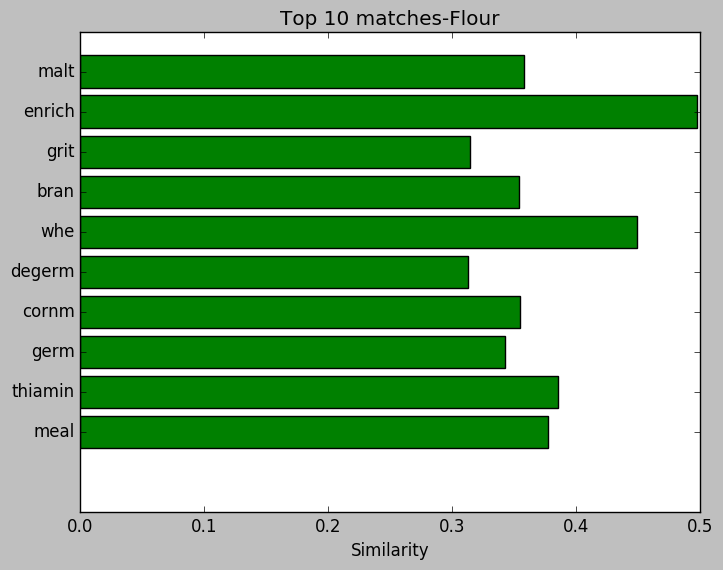

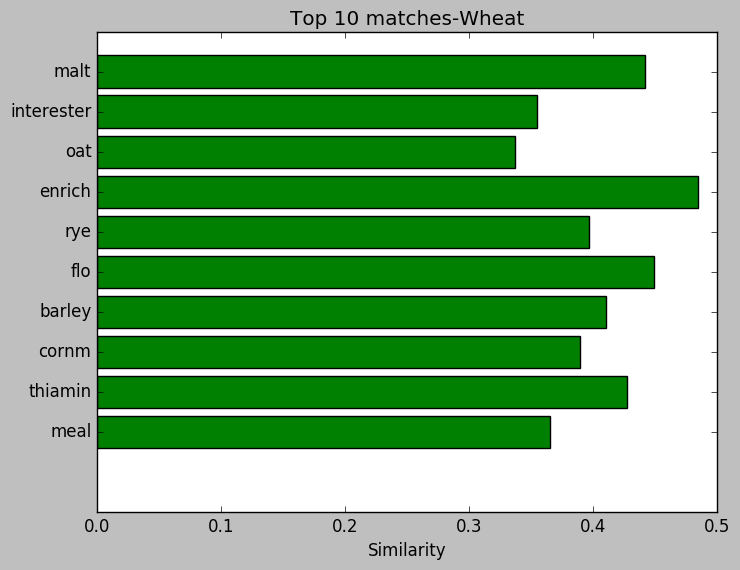

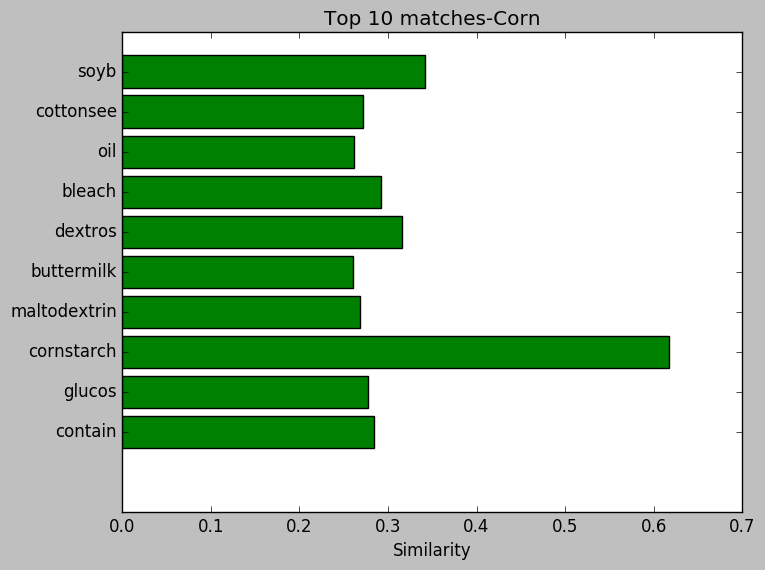

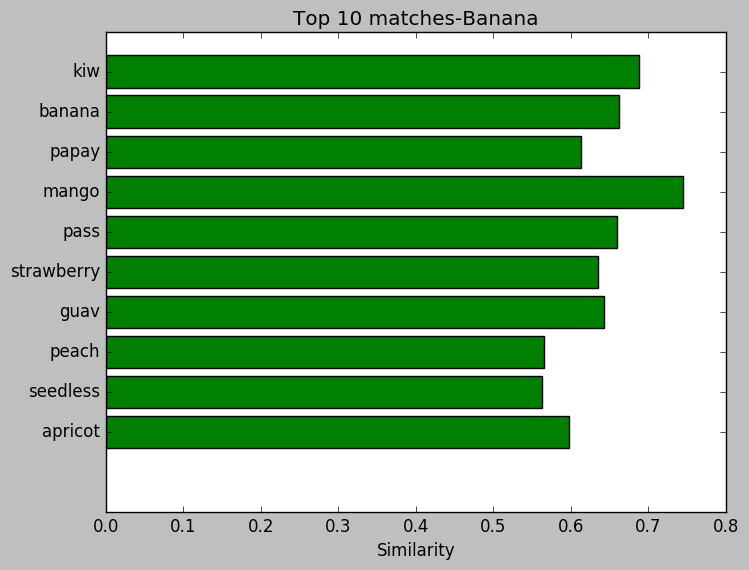

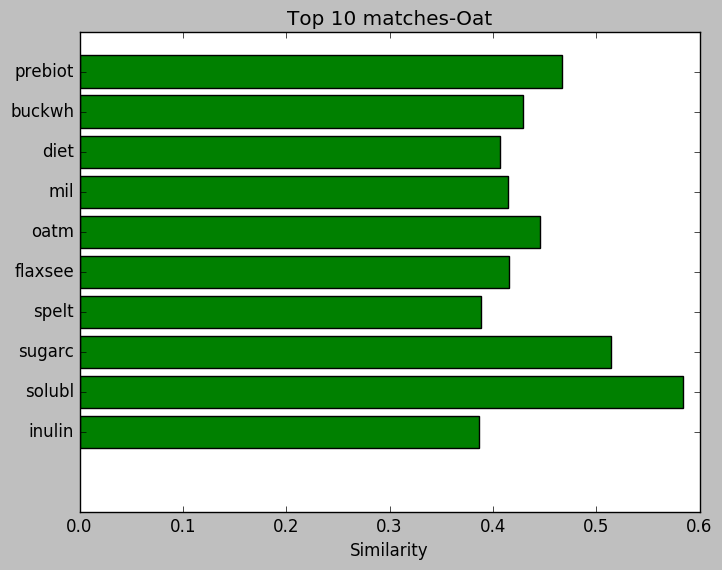

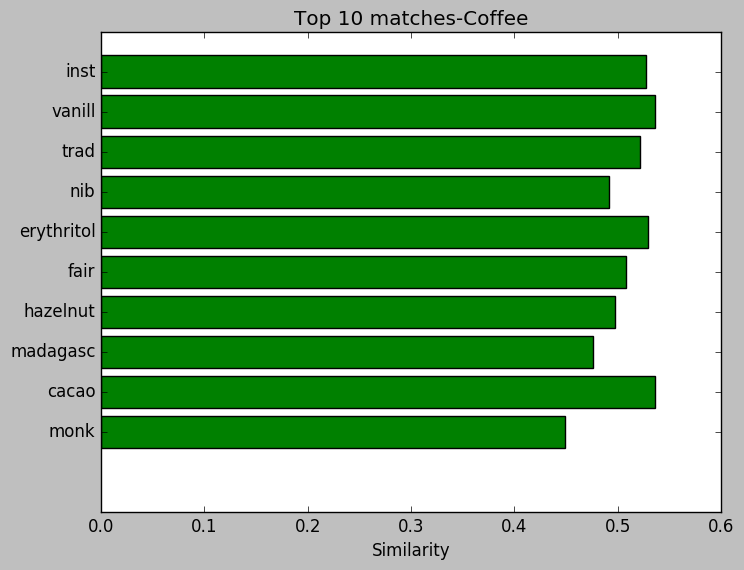

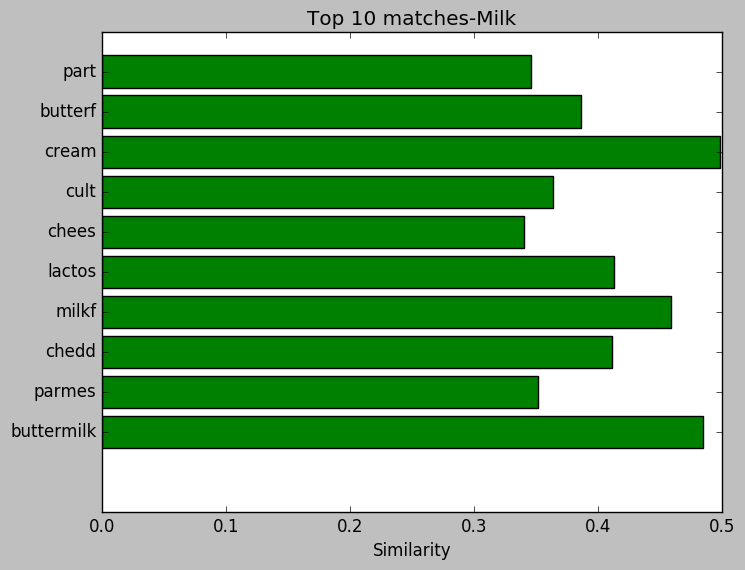

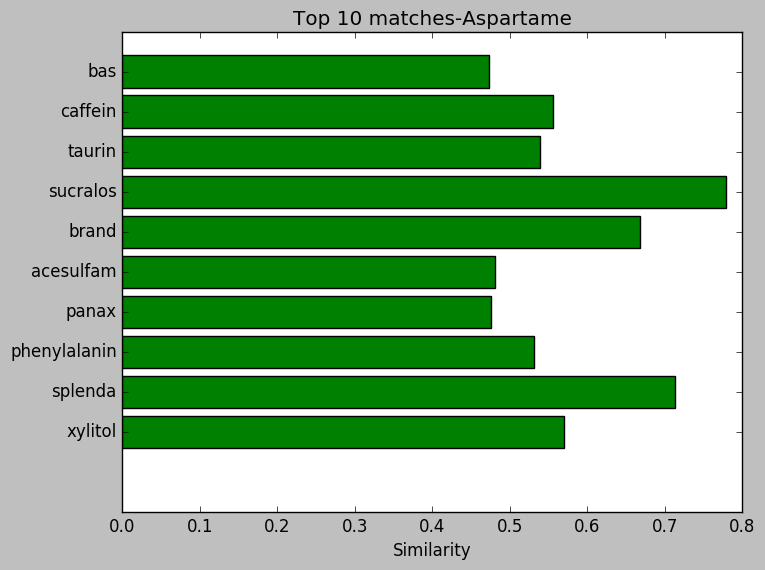

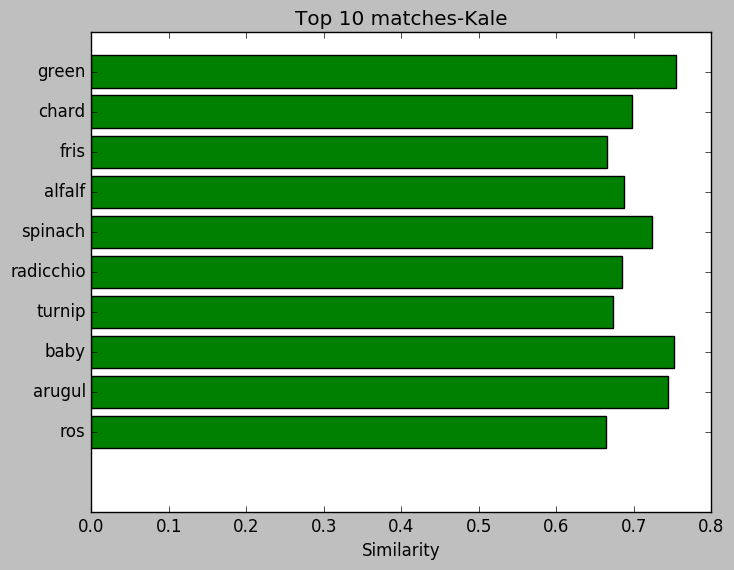

In [670]:
#visualize the differences
ING=['Flour','Wheat','Corn','Banana','Oat','Coffee','Milk','Aspartame','Kale']

for ing in ING:
    D=dict(frimodel.wv.most_similar(positive=[ls.stem(ing)], topn=10) ) 

    plt.rcdefaults()
    fig, ax = plt.subplots()

    # Example data
    people = list(D.keys())
    y_pos = np.arange(len(people))
    performance = list(D.values()) 

    ax.barh(y_pos, performance,   align='center',
            color='green', ecolor='black')
    ax.set_yticks(y_pos)
    ax.set_yticklabels(people)
    #ax.invert_yaxis()  # labels read top-to-bottom
    ax.set_xlabel('Similarity')
    ax.set_title('Top 10 matches-'+ing)
    plt.savefig(ing, dpi=None, facecolor='w', edgecolor='w',
        orientation='portrait', papertype=None, format=None,
        transparent=False, bbox_inches=None, pad_inches=0.1,
        frameon=None, metadata=None)
    plt.show()

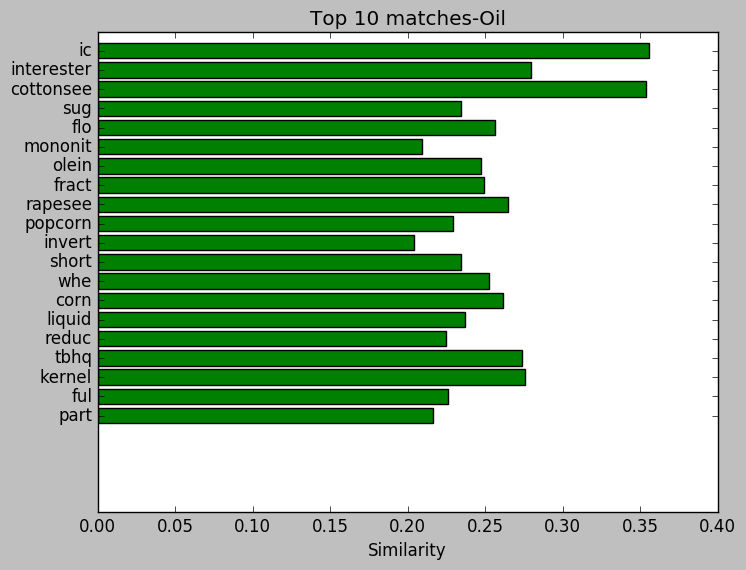

In [681]:
D=dict(frimodel.wv.most_similar(positive=[ls.stem('oil')], topn=20) ) 

plt.rcdefaults()
fig, ax = plt.subplots()

# Example data
people = list(D.keys())
y_pos = np.arange(len(people))
performance = list(D.values()) 

ax.barh(y_pos, performance,   align='center',
        color='green', ecolor='black')
ax.set_yticks(y_pos)
ax.set_yticklabels(people)
#ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Similarity')
ax.set_title('Top 10 matches-Oil')
plt.savefig(ing, dpi=None, facecolor='w', edgecolor='w',
    orientation='portrait', papertype=None, format=None,
    transparent=False, bbox_inches=None, pad_inches=0.1,
    frameon=None, metadata=None)
plt.show()

from nltk.corpus import stopwords

sw = stopwords.words("english")

In [671]:
from gensim.test.utils import datapath
#save model
frimodel.save('/tmp/sunmodelf')
frimodel.save('sunmodelf')



2019-02-17 12:26:59,404 : INFO : saving Word2Vec object under /tmp/sunmodelf, separately None
2019-02-17 12:26:59,410 : INFO : not storing attribute vectors_norm
2019-02-17 12:26:59,412 : INFO : not storing attribute cum_table
2019-02-17 12:26:59,588 : INFO : saved /tmp/sunmodelf
2019-02-17 12:26:59,589 : INFO : saving Word2Vec object under sunmodelf, separately None
2019-02-17 12:26:59,591 : INFO : not storing attribute vectors_norm
2019-02-17 12:26:59,592 : INFO : not storing attribute cum_table
2019-02-17 12:26:59,630 : INFO : saved sunmodelf


In [75]:
frimodel=gensim.models.Word2Vec.load("frimodel")

2019-02-07 17:24:10,856 : INFO : loading Word2Vec object from /tmp/w2vmodeltue
2019-02-07 17:24:11,483 : INFO : loading trainables recursively from /tmp/w2vmodeltue.trainables.* with mmap=None
2019-02-07 17:24:11,513 : INFO : loading wv recursively from /tmp/w2vmodeltue.wv.* with mmap=None
2019-02-07 17:24:11,518 : INFO : setting ignored attribute vectors_norm to None
2019-02-07 17:24:11,691 : INFO : loading vocabulary recursively from /tmp/w2vmodeltue.vocabulary.* with mmap=None
2019-02-07 17:24:11,693 : INFO : setting ignored attribute cum_table to None
2019-02-07 17:24:11,707 : INFO : loaded /tmp/w2vmodeltue


In [674]:
#vecs=np.array
def recipe2vec(recipe): # 'word' meaning ingredient in "recipe" which is a list of ingredients
    if len(recipe)<2:recipe='oddword'
    vec = np.sum( [frimodel.wv[word]
                                for word in recipe if word in frimodel.wv.vocab] or
                 [np.zeros(400, dtype=float)  
                            for word in recipe if word not in frimodel.wv.vocab],axis=0)
    return vec.reshape(1,400) 
#type(recipe2vec(cleanedwords[0])),recipe2vec(cleanedwords[0])
vectorall = np.array([recipe2vec(recipe) for recipe in cleanedwords2])


In [675]:
print(vectorall.shape) 
vecsuseS=vectorall.reshape(len(cleanedwords2) ,400)

vecsuseS.shape

(152093, 1, 400)


(152093, 400)

In [676]:
import pickle
#pickle.dump(vecsuse, open("vecsuse.pkl", 'wb'))
#newfile=pickle.load(open ('vecsuse.pkl,'rb'))

In [679]:
#save array
import pickle
file = open('vecsuseS.pkl', 'rb')
vecsapp = pickle.load(file)
file.close() 

In [3]:
#obtain pickled array
import pickle
vecsuseS=pickle.load(open ('vecsuseS.pkl','rb'))

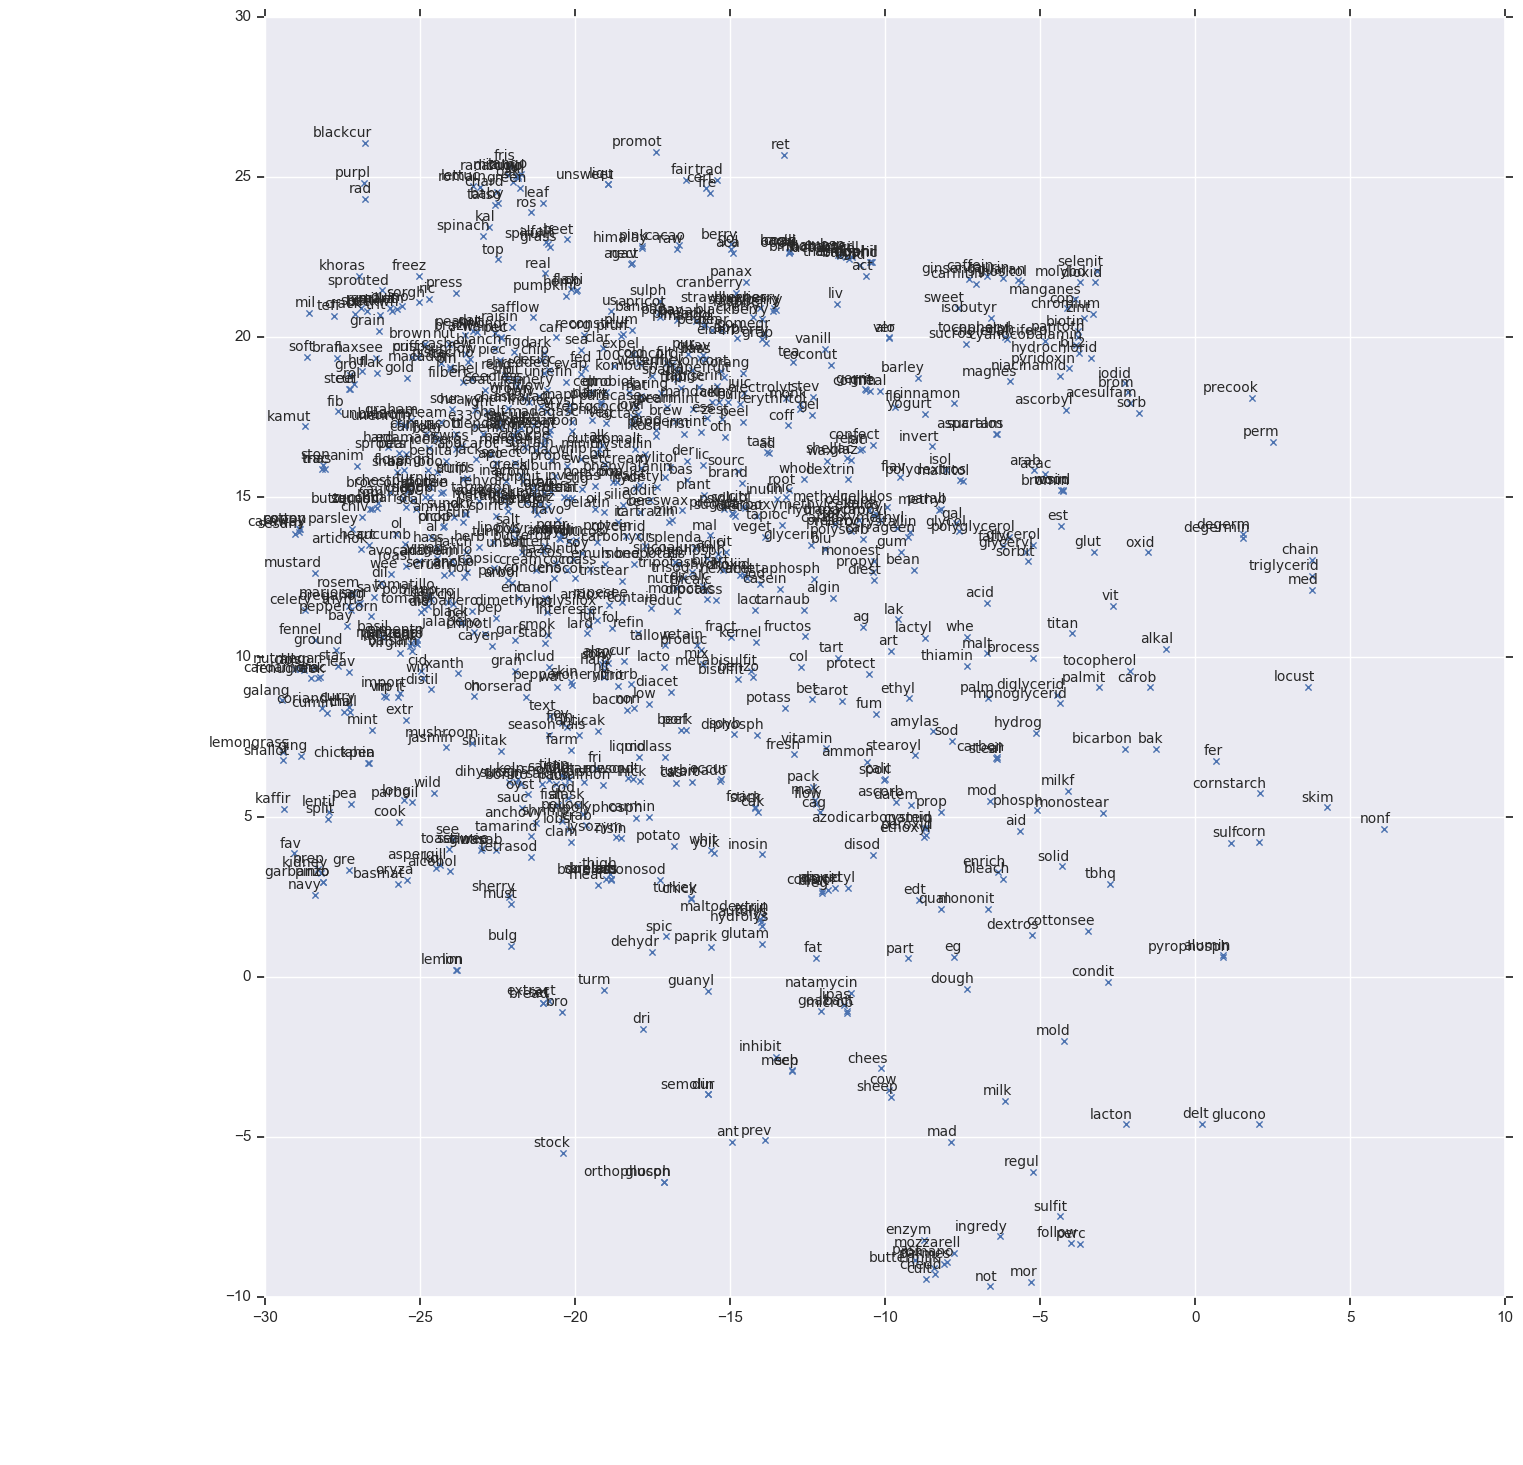

In [692]:
#visualize ingredient vectors
from sklearn.manifold import TSNE

def tsne_plot(model):
    "Creates and TSNE model and plots it"
    labels = []
    tokens = []
    sns.set()


    for word in frimodel.wv.vocab:
        if len(word)>2 & (word not in customstopwords):
            
        #if word in prunedlist:
            tokens.append(model.wv.__getitem__(word))
            labels.append(word)
    
    tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
    new_values = tsne_model.fit_transform(tokens)

    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])

    
    plt.figure(figsize=(16, 16)) 
    for i in range(len(x)):
        plt.scatter(x[i],y[i],marker='x' )
        plt.annotate(labels[i],size=10,
                     xy=(x[i], y[i], ),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
        plt.xlim(-30, 10)
        plt.ylim(-10,30);
        plt.title('Ingredient vectors projected onto 2 dimensions using tSNE')
        plt.axes()
    plt.show()
    return
tsne_plot(frimodel)

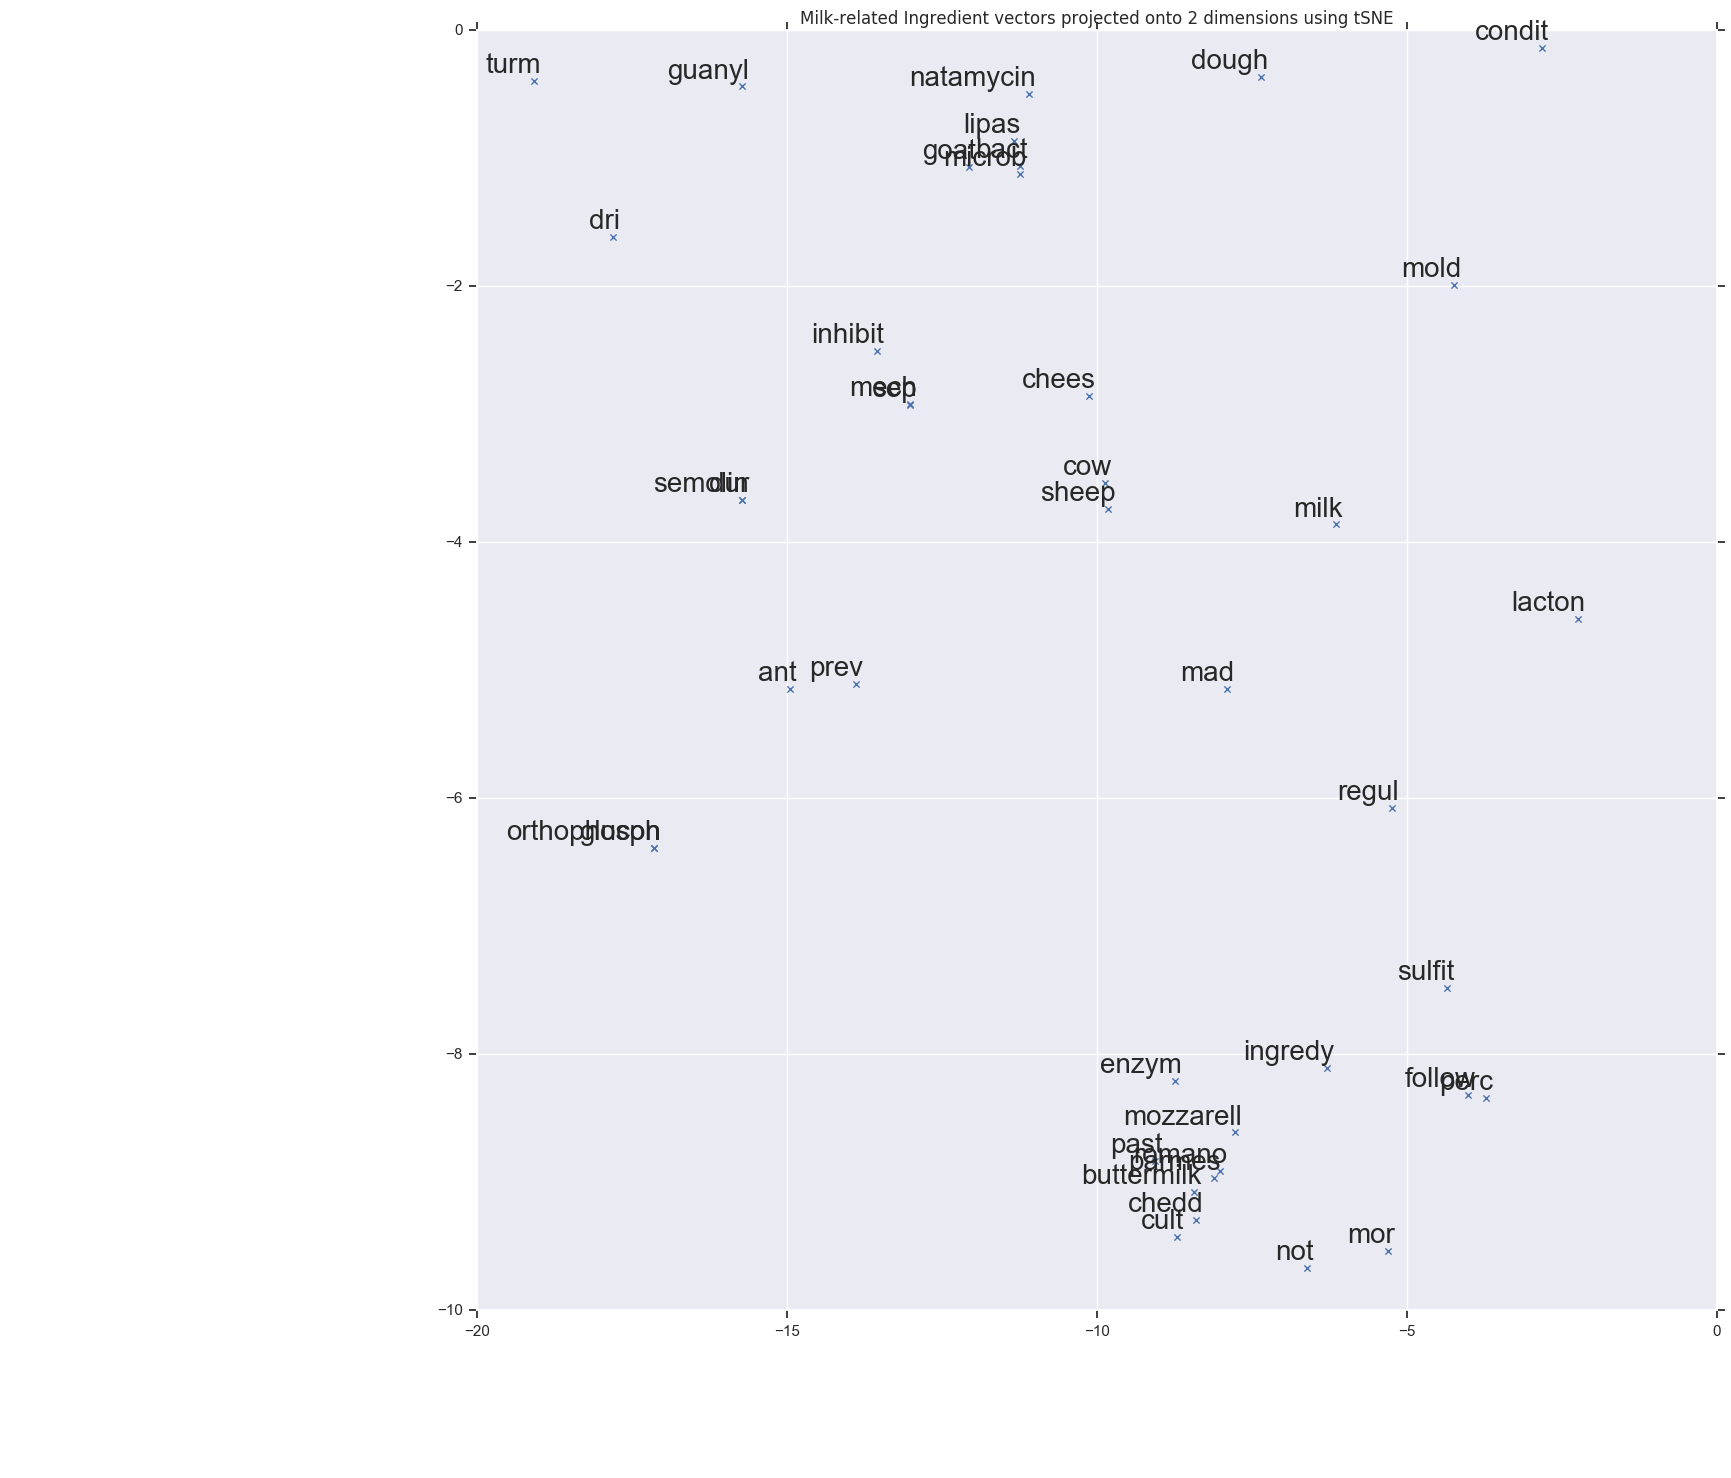

In [694]:
from sklearn.manifold import TSNE

def tsne_plot(model):
    "Creates and TSNE model and plots it"
    labels = []
    tokens = []
    sns.set()


    for word in frimodel.wv.vocab:
        if len(word)>2 & (word not in customstopwords):
            
        #if word in prunedlist:
            tokens.append(model.wv.__getitem__(word))
            labels.append(word)
    
    tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
    new_values = tsne_model.fit_transform(tokens)

    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])

    
    plt.figure(figsize=(16, 16)) 
    for i in range(len(x)):
        plt.scatter(x[i],y[i],marker='x' )
        plt.annotate(labels[i],size=20,
                     xy=(x[i], y[i], ),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
        plt.xlim(-20, 0)
        plt.ylim(-10,0);
        plt.title('Milk-related Ingredient vectors projected onto 2 dimensions using tSNE',)
        plt.axes()
    plt.show()
    return
tsne_plot(frimodel)

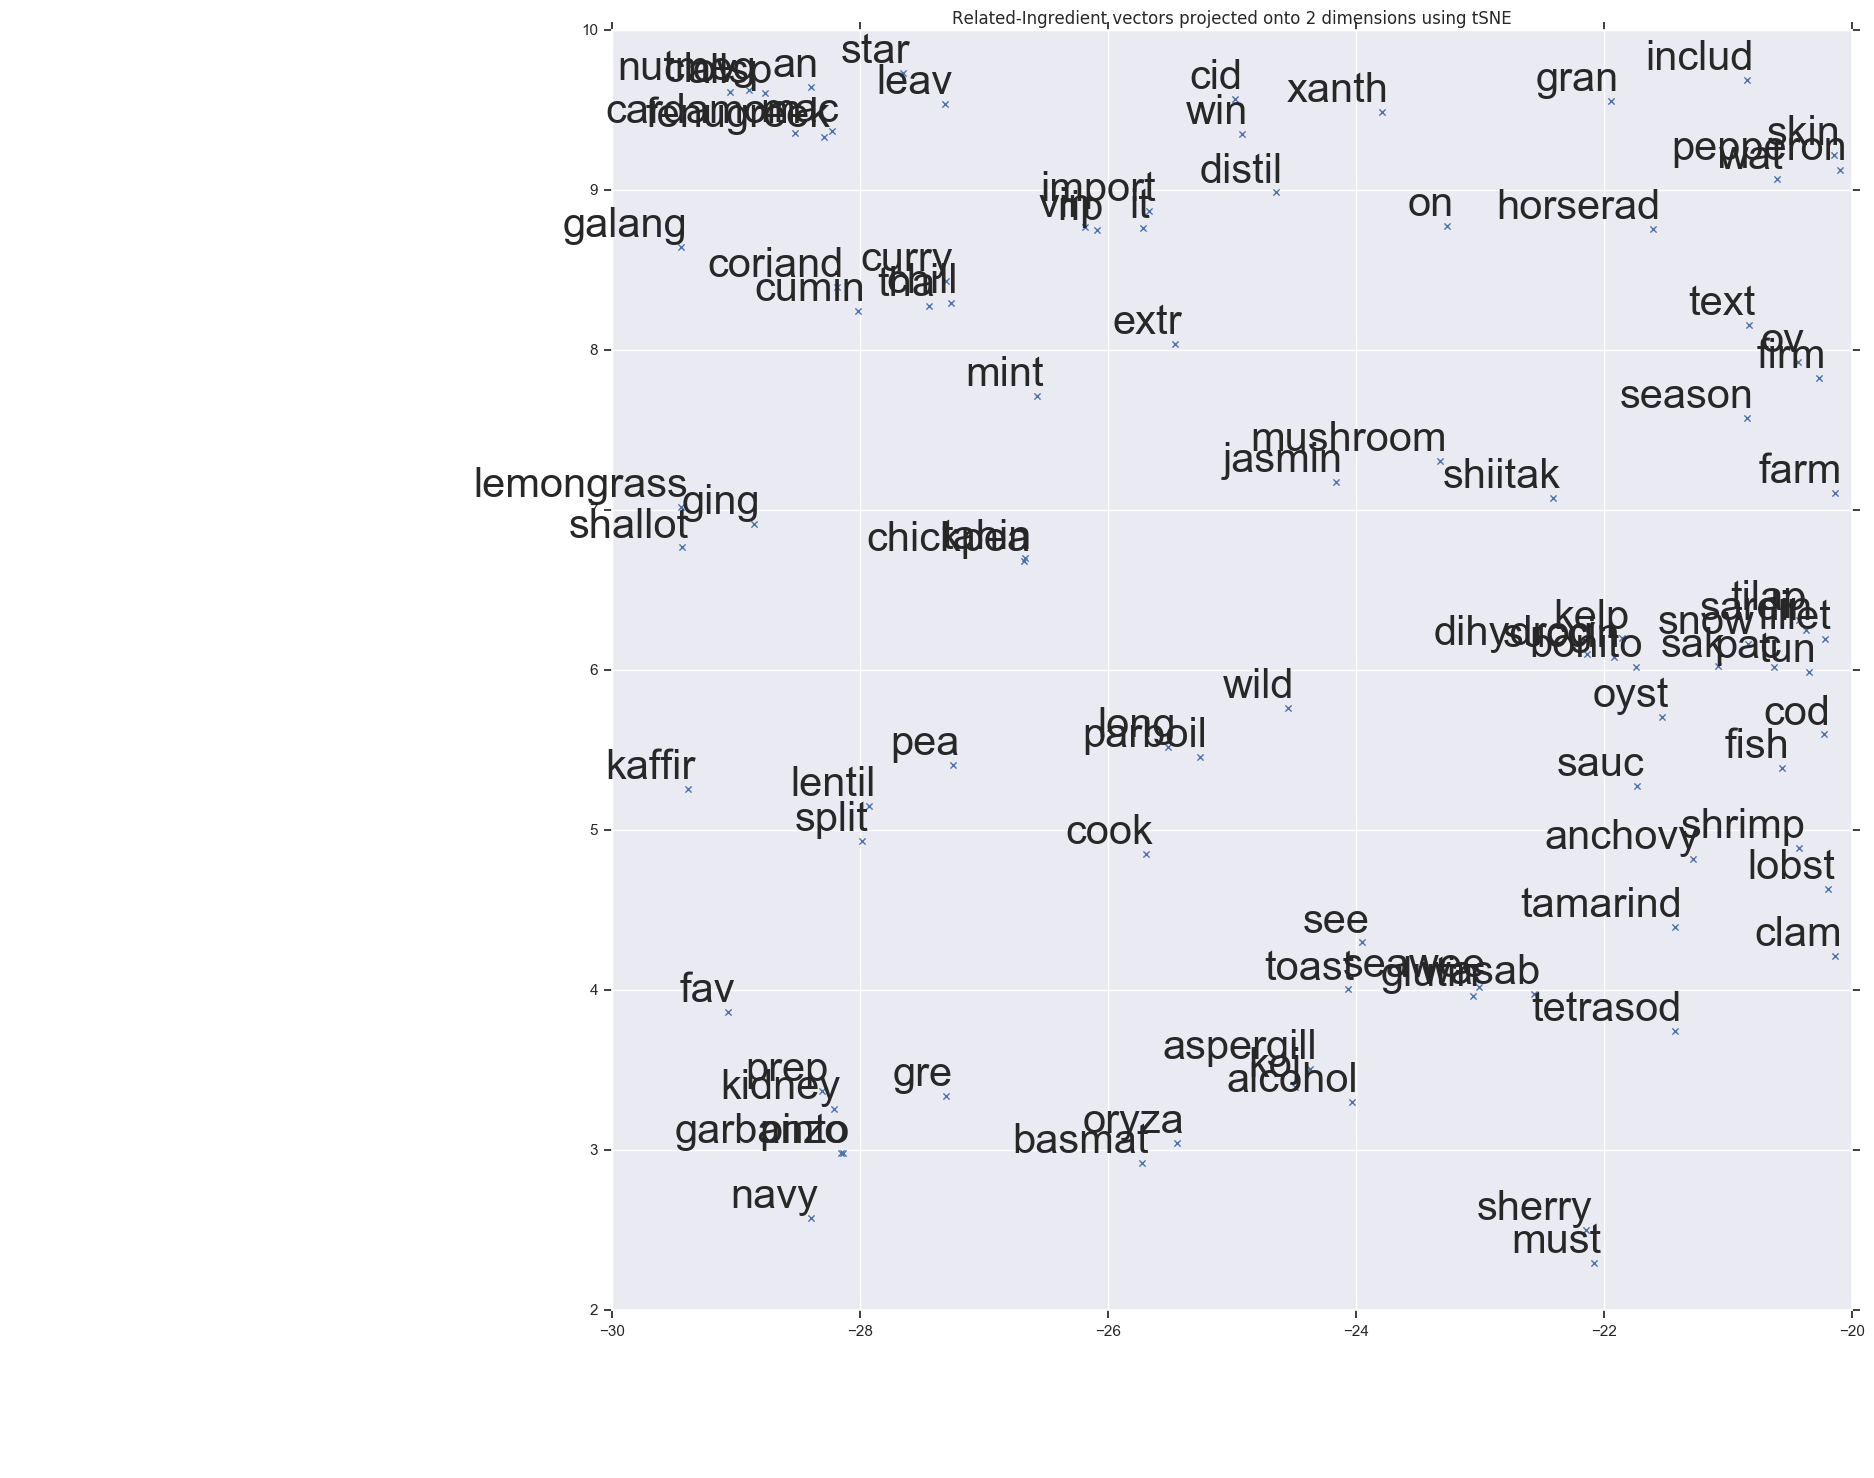

In [697]:
from sklearn.manifold import TSNE

def tsne_plot(model):
    "Creates and TSNE model and plots it"
    labels = []
    tokens = []
    sns.set()


    for word in frimodel.wv.vocab:
        if len(word)>2 & (word not in customstopwords):
            
        #if word in prunedlist:
            tokens.append(model.wv.__getitem__(word))
            labels.append(word)
    
    tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
    new_values = tsne_model.fit_transform(tokens)

    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])

    
    plt.figure(figsize=(16, 16)) 
    for i in range(len(x)):
        plt.scatter(x[i],y[i],marker='x' )
        plt.annotate(labels[i],size=30,
                     xy=(x[i], y[i], ),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom',)
        plt.ylim(2, 10)
        plt.xlim(-30,-20);
        plt.title('Related-Ingredient vectors projected onto 2 dimensions using tSNE')
        plt.axes()
    plt.show()
    return
tsne_plot(frimodel)

In [7]:
proquant=pd.read_csv('proquantfeb17.csv')
len(proquant)


/Users/meleciawright/anaconda/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (23,27) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


152093

In [8]:
#obtain pickled array
import pickle
vecsuseS=pickle.load(open ('vecsuseS.pkl','rb'))
vecsuseS.shape

(152093, 400)

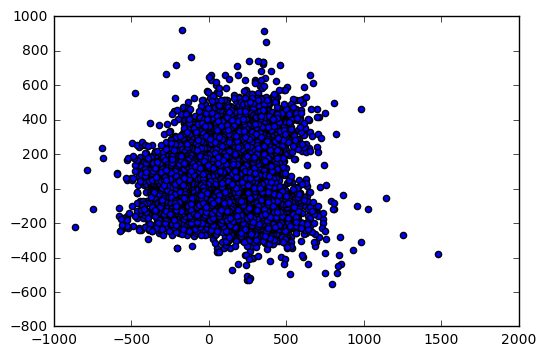

In [6]:
#all products
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
result = pca.fit_transform(vecsuseS)
plt.scatter(result[:, 0], result[:, 1])
plt.show()

In [9]:
proquant.pcat.value_counts().index.tolist()

['uncategorized',
 'meatburger',
 'pasta',
 'cereal',
 'yogurt',
 'soup',
 'ice cream']

In [11]:
#grab the indexes so that you can color different categories
soupvec=proquant[proquant.pcat=='soup'].index.tolist()
#soupvecind=np.random.randint(len(soupvec), size=500)
icecreamvec=proquant[proquant.pcat=='ice cream'].index.tolist()
#icecreamvecind=np.random.randint(len(icecreamvec), size=500)
meatvec=proquant[proquant.pcat=='meatburger'].index.tolist()
#meatvecind=np.random.randint(len(meatvec), size=500)
pastavec=proquant[proquant.pcat=='pasta'].index.tolist()
# pastavecind=np.random.randint(len(pastavec), size=500)

cerealvec=proquant[proquant.pcat=='cereal'].index.tolist()
# cerealvecind=np.random.randint(len(vvec), size=500)

In [13]:
resultice= result[icecreamvec]
resultmeat = result[meatvec]
resultpasta = result[pastavec]
resultcereal = result[cerealvec]
resultsoup=result[soupvec]

result.shape,resultice.shape,len(icecreamvec)

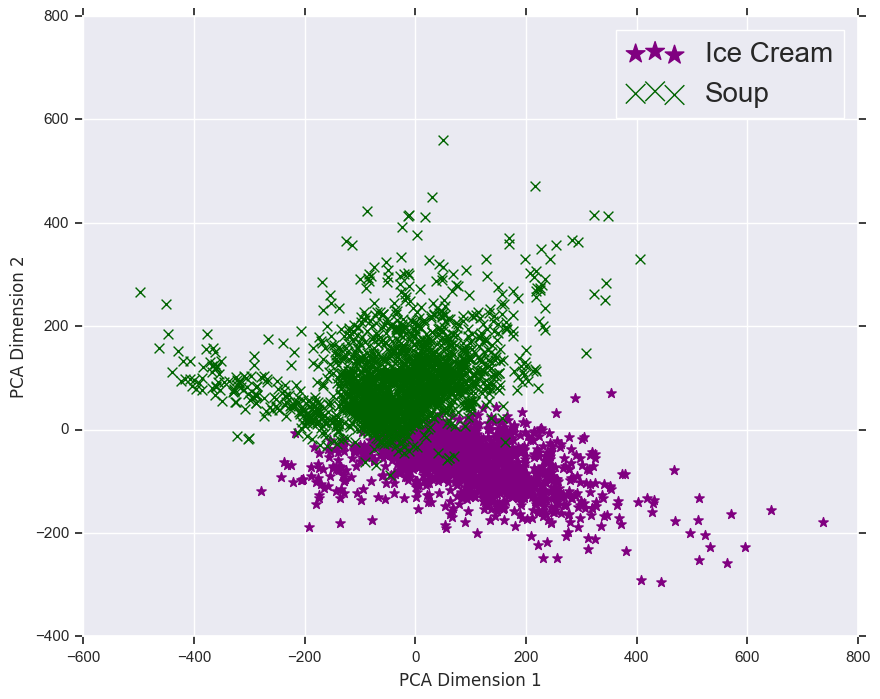

In [104]:

plt.figure(figsize=(10,8))

plt.scatter(resultice[:, 0], resultice[:, 1] , s=50,  marker='*' , c='purple',edgecolor='face' )
plt.scatter(resultsoup[:, 0], resultsoup[:, 1],s=50,  marker='x' , c='darkgreen',edgecolor='face')
plt.legend(['Ice Cream','Soup'],fontsize=20,markerscale=2 )
#plt.title('Product categories are distinguishable',fontsize=40)
plt.xlabel('PCA Dimension 1')
plt.ylabel('PCA Dimension 2')
plt.show()


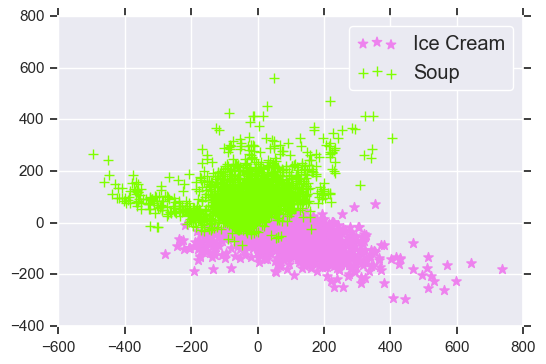

In [81]:
#sns.set()

plt.scatter(resultice[:, 0], resultice[:, 1] , s=50,  marker='*' , c='VIOLET',edgecolor='face' )
plt.scatter(resultsoup[:, 0], resultsoup[:, 1],s=50,  marker='+' , c='CHARTREUSE',edgecolor='face')
plt.legend(['Ice Cream','Soup'],fontsize='large',fancybox=True,)
plt.show()



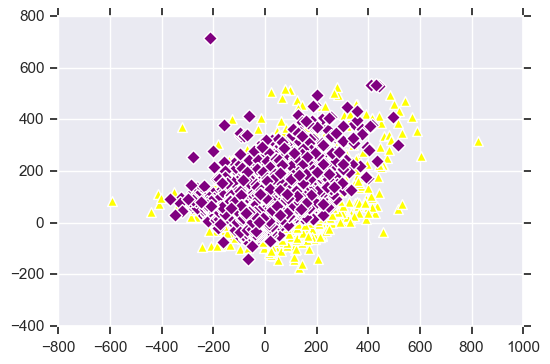

In [72]:
plt.scatter(resultmeat[:, 0], resultmeat[:, 1] , s=50,  marker='^' , c='yellow' )
plt.scatter(resultpasta[:, 0], resultpasta[:, 1],s=50,  marker='D' , c='purple')
plt.show()

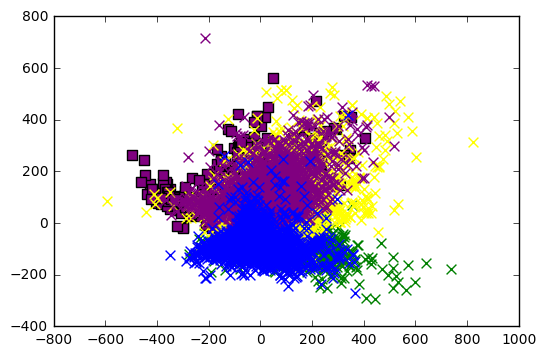

In [51]:

plt.scatter(resultice[:, 0], resultice[:, 1] , s=50,  marker='x' , c='green' )
plt.scatter(resultsoup[:, 0], resultsoup[:, 1],s=50,  marker='s' , c='purple')
plt.scatter(resultmeat[:, 0], resultmeat[:, 1] , s=50,  marker='x' , c='yellow' )
plt.scatter(resultpasta[:, 0], resultpasta[:, 1],s=50,  marker='x' , c='purple')
plt.scatter(resultcereal[:, 0], resultcereal[:, 1] ,s=50, marker='x' , c='blue')
plt.show()

In [ ]:
soupvec=proquant[proquant.pcat=='soup'].index.tolist()
len(soupvec)
soupvecind=np.random.randint(len(soupvec), size=500)
len(soupvecind)
icecreamvec=proquant[proquant.pcat=='ice cream'].index.tolist()
print(len(icecreamvec))
icecreamvecind=np.random.randint(len(icecreamvec), size=500)
len(icecreamvecind)
meatvec=proquant[proquant.pcat=='meat/burgers'].index.tolist()
len(meatvec)
meatvecind=np.random.randint(len(meatvec), size=500)
len(meatvecind)
cakevec=proquant[proquant.pcat=='cake'].index.tolist()
print(len(cakevec))
cakevecind=np.random.randint(len(cakevec), size=500)
len(cakevecind)

#from sklearn.decomposition import PCA
vecicecream=vecsuse[icecreamvecind]
vecsoup=vecsuse[soupvecind]

meatvec=vecsuse[meatvecind]
cakevec=vecsuse[cakevecind]
pca = PCA(n_components=2)


resultice = pca.fit_transform(vecicecream)
resultsoup=pca.fit_transform(vecsoup)
resultmeat = pca.fit_transform(meatvec)
resultcake=pca.fit_transform(cakevec)
 
#plt.set_cmap('BrBG')
from matplotlib import cm


plt.scatter(resultice[:, 0], resultice[:, 1] , s=50,  marker='x' , c='green' )
plt.scatter(resultsoup[:, 0], resultsoup[:, 1],s=50,  marker='s' , c='purple')

plt.scatter(resultmeat[:, 0], resultmeat[:, 1] ,s=50, marker='8' , c='black')
plt.scatter(resultcake[:, 0], resultcake[:, 1] ,s=50,  marker='o' , c='blue')
#'8', 's', 'p', '*', 'h'
plt.xlim(-50,50)
plt.ylim(-50,50);
#plt.xlim(-500,500)
#plt.ylim(-500,500);
plt.show()

In [ ]:
from sklearn.manifold import TSNE

def tsne_prod(model):
    "Creates and TSNE model and plots it"
    labels = []
    tokens = []
    sns.set()


    for word in frimodel.wv.vocab:
        if len(word)>2 & (word not in customstopwords):
            
        #if word in prunedlist:
            tokens.append(model.wv.__getitem__(word))
            labels.append(word)
    
    tsne_prodmodel = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
    tsproducts = tsne_model.fit_transform(vecsuseS)

    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])

    
    plt.figure(figsize=(16, 16)) 
    for i in range(len(x)):
        plt.scatter(x[i],y[i],marker='x' )
        plt.annotate(labels[i],size=30,
                     xy=(x[i], y[i], ),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom',)
        plt.ylim(2, 10)
        plt.xlim(-30,-20);
        plt.title('Related-Ingredient vectors projected onto 2 dimensions using tSNE')
        plt.axes()
    plt.show()
    return
tsne_prod(vec)

In [ ]:
from sklearn.manifold import TSNE

tsne_prodmodel = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
tsproducts = tsne_prodmodel.fit_transform(vecsuseS)



In [1]:
1+2

3